In [1]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

from tqdm import tqdm


# Simulate Data

In [2]:
import importlib
import sys
import os 
sys.path.insert(0, os.path.abspath(os.path.join('../src/')))
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

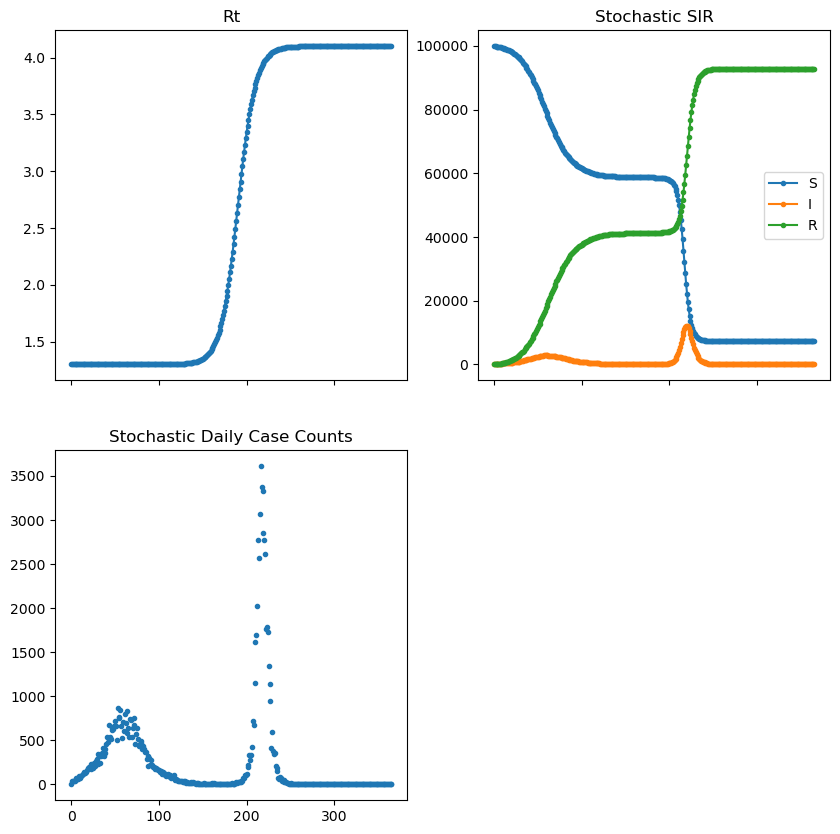

In [108]:
# true_params = {
#     'rt_0': 1.4,
#     'rt_1': 3.,
#     'midpoint': 100.,
#     'k': 0.1,
#     'n_t': 365,
#     't_I': 4.,
#     'N': 100_000.,
#     'S0': 99_900.,
#     'I0': 100.,
# }

true_params = {
    'rt_0': 1.3,
    'rt_1': 4.1,
    'midpoint': 190.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

# true_params = {
#     'rt_0': 1.4,
#     'rt_1': 3.,
#     'midpoint': 100.,
#     'k': 0.1,
#     'n_t': 365,
#     't_I': 4.,
#     'N': 100_000.,
#     'S0': 99_900.,
#     'I0': 100.,
# }


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

# Adaptive Inflation
Based on JL Anderson (2008)

In [109]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

beta = data.construct_beta(data.rt, data.t_I)

x = SIR(
    S = data.S0,
    I = data.I0,
    R = 0,
    i = 0
)
θ = ModelParams(beta, data.t_I)

In [110]:
def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
    dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

def g(x):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    # y = np.random.binomial(x.i.astype(int), α)
    return x.i

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """
#     I0 = pop * inf_init
#     S0 = pop - I0
#     R0 = 0
#     i = 0

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

In [111]:
# def _adaptive_inflation(x, y, z, oev, lambar_prior=1.01, siglam2=0.001):
#     # step 3b
#     sig2p = np.var(y)
#     ybarp = np.mean(y)
#     D = np.abs(ybarp - z) * z / 50

#     # step 3c
#     # r = np.cov(x, y)[0, 1]  # i
#     r = np.corrcoef(x,y)[0,1]  # i
#     lam0 = (1.0 + r * (np.sqrt(lambar_prior) - 1.0)) ** 2  # iii
#     theta = np.sqrt(lam0 * sig2p + oev)  # iv

#     # v/ Appendix A
#     lbar = 1.0 / (np.sqrt(2 * np.pi) * theta) * np.exp(-(D**2) / (2.0 * theta**2))
#     dthetadlam = (
#         sig2p
#         * r
#         * (1.0 - r + r * np.sqrt(lambar_prior))
#         / (2.0 * theta * np.sqrt(lambar_prior))
#     )
#     lprime = lbar * (D**2 / theta**2 - 1.0) / theta * dthetadlam

#     b = lbar / lprime - 2 * lambar_prior
#     c = lambar_prior**2 - siglam2 - lbar * lambar_prior / lprime

#     lam1 = np.abs((-b + np.sqrt(b**2 - 4.0 * c)) / 2)
#     lam2 = np.abs((-b - np.sqrt(b**2 - 4.0 * c)) / 2)

#     if np.abs(lam1 - lambar_prior) < np.abs(lam2 - lambar_prior):
#         return lam1
#     else:
#         return lam2


# def _inflate_ensembles(ens, inflation_value, params=False):
#     if params:
#         _, m = np.asarray(ens).shape
#         ens_mean = np.mean(ens, 1, keepdims=True)
#         ens_inflated = ens_mean * np.ones((1, m)) + inflation_value * (
#             ens - ens_mean * np.ones((1, m))
#         )
#     else:
#         m = len(ens)
#         ens_mean = np.mean(ens)
#         ens_inflated = ens_mean * np.ones(m) + inflation_value * (
#             ens - ens_mean * np.ones(m)
#         )

#     return ens_inflated

In [112]:
def reprobe(x, prior, m):
    """
    Reprobe ensemble
        Args:
            x (nd.array) : ensemble
            prior (dict) : prior 
            m (int)      : number of ensemble members to reprobe
    """
    
    return x_probed

In [113]:
def eakf(x, y, z, oev, m=3000):
    """
    Args:
        x: latenet state rv or latent parameter rv
        y: observed rv
        z: observation
        oev: observational error variance
    """
    x = np.array(x)
    y = np.array(y)
    
    p, m = x.shape

    mu_prior  = y.mean()
    var_prior = y.var()

    # degenerate prior.
    var_prior = np.where(var_prior == 0., 1e-3, var_prior)

    var_post = var_prior * oev / (var_prior + oev)
    mu_post  = var_post  * (mu_prior/var_prior + z/oev)
    alpha    = (oev / (oev + var_prior)) ** (0.5)
    dy       = (mu_post - y) + alpha * (y - mu_prior)
    
    # compute covariance
    rr = np.full((p, 1), np.nan)

    # import pdb; pdb.set_trace()
    for ip in range(p):
        A  = np.cov(x[ip, :], y)
        rr[ip,:] =  A[1, 0] / var_prior
    dx = np.dot(rr, dy.reshape((1,m)))
    # rr = np.cov(x, y)[:-1,-1] / var_prior
    # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

    xpost = x + dx
    ypost = y + dy

    return xpost, ypost, alpha

In [114]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}



In [115]:
from tqdm import tqdm

x_list = []
θ_list = []
lam_list = []
alpha_list = []

m = 300
turn_off = False

lam = lam_S = lam_I = lam_R = lam_i = 1.01

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N, m=m)
        θ = θ0(prior, m=m)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x)           # analysis
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        if t > 50:
            lam = _adaptive_inflation(θ.beta, y, z, oev, lambar_prior=lam)
            lam_S = _adaptive_inflation(x.S, y, z, oev)
            lam_I = _adaptive_inflation(x.I, y, z, oev)
            lam_R = _adaptive_inflation(x.R, y, z, oev)
            lam_i = _adaptive_inflation(x.i, y, z, oev)
            # if z > 0:
            #     if np.abs(np.mean(y) - z) / z > 1:
            #         turn_off = True
            #         lam = 1.
            #         lam_S = 1.
            #         lam_I = 1.
            #         lam_R = 1.
            #         lam_i = 1.
            if np.isnan(lam):
                lam = 1.
            if np.isnan(lam_S):
                lam_S = 1.
            if np.isnan(lam_I):
                lam_I = 1.
            if np.isnan(lam_R):
                lam_R = 1.
            if np.isnan(lam_i):
                lam_i = 1.
            # if turn_off:
            #     lam = 1.
            #     lam_S = 1.
            #     lam_I = 1.
            #     lam_R = 1.
            #     lam_i = 1.
            lam_list.append(lam)
            θ = _inflate_ensembles(θ, inflation_value=lam, params=True)
            θ = np.clip(θ, 0, 10)
            # print(lam)
            θ = ModelParams(*θ)
        
            # print(lam_S, lam_I, lam_R)
            S = _inflate_ensembles(x.S, inflation_value=lam_S)
            I = _inflate_ensembles(x.I, inflation_value=lam_I)
            R = _inflate_ensembles(x.R, inflation_value=lam_R)
            i = _inflate_ensembles(x.i, inflation_value=lam_i)

            x = SIR(
                S = np.clip(S, 0, data.N),
                I = np.clip(I, 0, data.N),
                R = np.clip(R, 0, data.N),
                i = np.clip(i, 0, data.N)
            )
        
        x, new_i, alpha = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _, alpha_θ = eakf(θ, y, z, oev=oev, m=m)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
        
        alpha_list.append([alpha, alpha_θ])
    
    x_list.append(x)
    θ_list.append(θ)


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_4059/2550450329.py:23: RuntimeWarning: invalid value encountered in double_scalars
  b = lbar / lprime - 2 * lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_4059/2550450329.py:24: RuntimeWarning: invalid value encountered in double_scalars
  c = lambar_prior**2 - siglam2 - lbar * lambar_prior / lprime


Text(0.5, 0.98, 'EAKF full time series adaptive inflation')

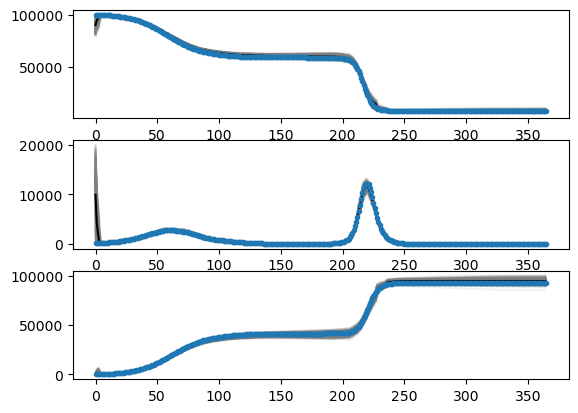

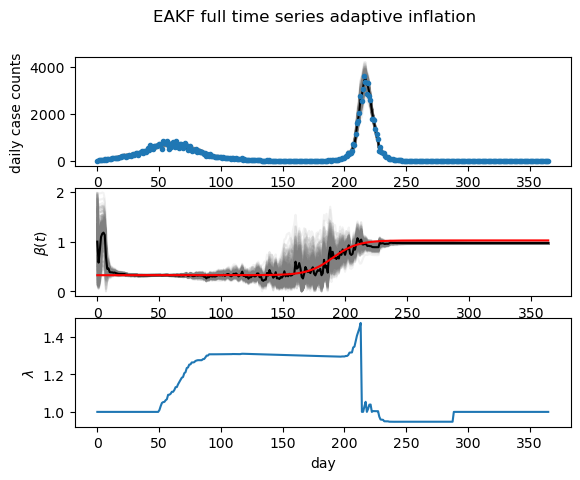

In [116]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(3)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')
ax[0].set_ylabel('daily case counts')

ax[1].plot([θ.beta for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

ax[2].plot(np.linspace(0,365,364), np.append(np.ones(50), lam_list))
ax[2].set_xlabel("day")
ax[2].set_ylabel(r"$\lambda$")

# fig.suptitle('EAKF full time series adaptive inflation, "truncated prior"')
fig.suptitle('EAKF full time series adaptive inflation')

In [138]:
def free_sim(beta):
    S = np.array([data.S0 * np.ones(300)])
    Ir = np.array([data.I0 * np.ones(300)])
    R = np.array([np.zeros(300)])
    i = np.array([np.zeros(300)])
    
    for t in range(beta.shape[0]):
        if t < 10:
            dSI = np.random.poisson(data.rt_0/data.t_I*Ir[t]*S[t]/data.N)
        else:
            dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
        dIR = np.random.poisson(Ir[t]/data.t_I)

        S_new = np.clip(S[t]-dSI, 0, data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
        R_new = np.clip(R[t]+dIR, 0, data.N)

        S = np.append(S, [S_new], axis=0)
        Ir = np.append(Ir, [I_new], axis=0)
        R = np.append(R, [R_new], axis=0)
        i = np.append(i, [dSI], axis=0)


    return S, Ir, R, i

In [143]:
def plot_reliability(θ_list):
    betas = np.asarray([θ.beta for θ in θ_list])
    S, Ir, R, i = free_sim(betas)
    
    fig, ax = plt.subplots(1)
    ax.plot(i, color='gray', alpha=0.1)
    ax.plot(data.i_true, 'x', color='black', label="truth")
    ax.set_title("free simulation - all ensembles")
    
    ci = np.quantile(i, q=[0.025, 0.975], axis=1)
    ci_50 = np.quantile(i, q=[0.25, 0.75], axis=1)
    
    fig, ax = plt.subplots(1)
    
    ax.fill_between(np.arange(0,366), ci[0], ci[1], facecolor='gray', alpha=0.5, label='95% CI')
    ax.fill_between(np.arange(0,366), ci_50[0], ci_50[1], facecolor='gray', alpha=0.75, label='50% CI')
    ax.plot(data.i_true, 'x', color='black', label="truth")
    ax.legend(loc='upper left')

    ax.set_title("free simulation")
    
    prop_95 = np.mean((ci[0] <= data.i) & (data.i <= ci[1]))
    prop_50 = np.mean((ci_50[0] <= data.i) & (data.i <= ci_50[1]))

    print(f"Percent of observations in 95% CI {round(prop_95*100, 2)}%")
    print(f"Percent of observations in 50% CI {round(prop_50*100, 2)}%")
    
    prop_list = []
    percentiles = np.arange(2.5, 100, 2.5)
    for p in percentiles:
        lower = np.quantile(i, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0,:]
        upper = np.quantile(i, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1,:]
        prop_list.append(np.mean((lower <= data.i) & (data.i <= upper)))
    
    fig, ax = plt.subplots(1)
    ax.plot(percentiles/100, prop_list, '-.')
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_xlabel('CI')
    ax.set_ylabel('% of obs within CI')
    ax.set_title("observation reliability plot")
    
    betas = np.asarray([θ.beta for θ in θ_list])
    betas_skip = betas[15:,:]
    beta_true = data.rt / data.t_I
    beta_true = beta_true[15:]

    prop_list = []
    for p in percentiles:
        lower = np.quantile(betas_skip, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0,:]
        upper = np.quantile(betas_skip, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1,:]
        prop_list.append(np.mean((lower <= beta_true) & (beta_true <= upper)))

    fig, ax = plt.subplots(1)
    ax.plot(percentiles/100, prop_list, '-.')
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_xlabel('CI')
    ax.set_ylabel(r'% of $\beta$ within CI')
    ax.set_title(r"$\beta$ reliability plot")
    
    for p in percentiles:
        S, Ir, R, i = free_sim(np.quantile(betas_skip, q = p/100))
        import pdb; pdb.set_trace()

Percent of observations in 95% CI 88.25%
Percent of observations in 50% CI 54.64%


IndexError: tuple index out of range

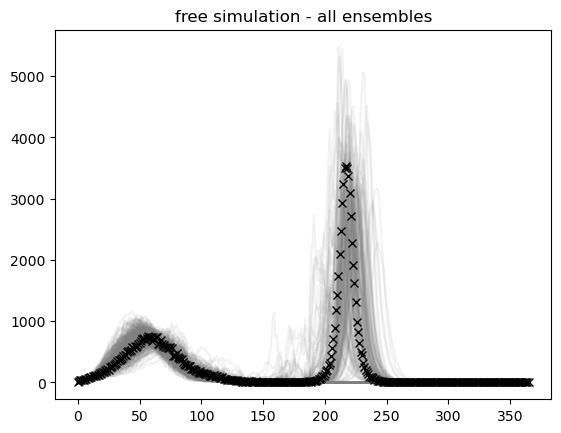

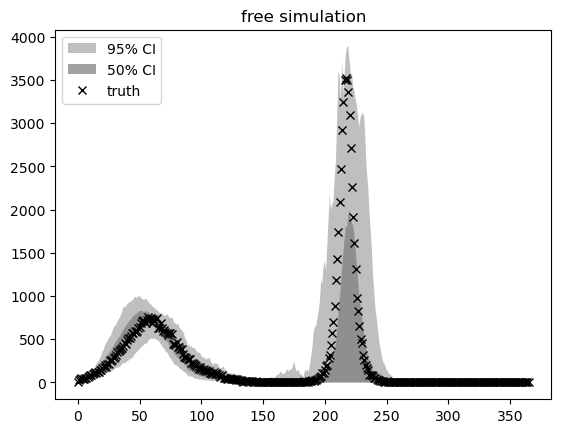

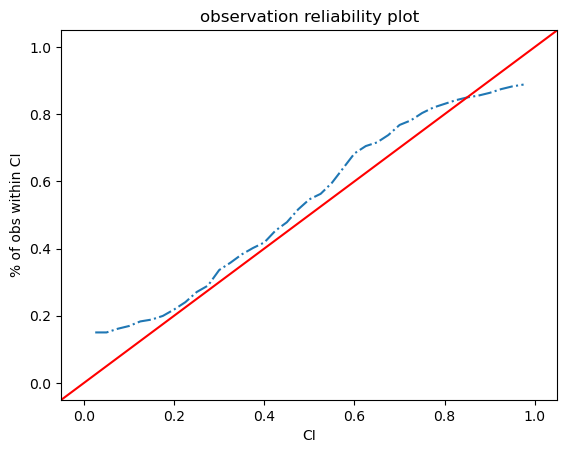

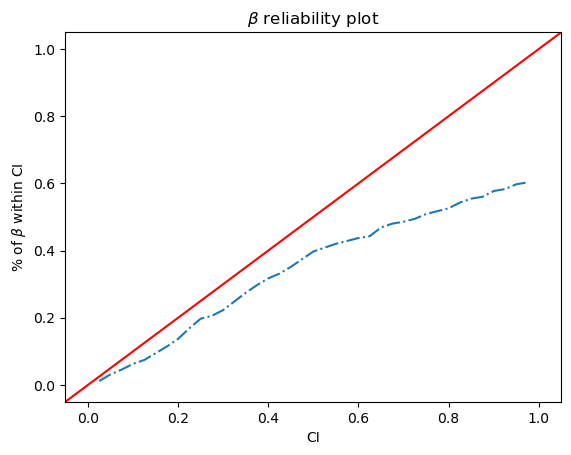

In [144]:
plot_reliability(θ_list)

In [82]:
# post_i = np.array([x.i for x in x_list])
# innovation = np.abs(np.mean(post_i, 1) - np.array([data.i[:-1]])) / np.array([data.i[:-1]])
# innovation.T[data.i[:-1] == 0] = np.nan
# plt.plot(innovation.T)
# plt.xlabel("day")
# plt.ylabel(r"$\frac{|\bar{y}_{a-1} - y^\dagger_{a-1}|}{y^\dagger_{a-1}}$")

In [83]:
# fig, ax = plt.subplots()
# tt = np.arange(0, 200)
# ens = np.array([θ.beta for θ in θ_list])
# ax.plot(tt, ens[0:200,:], color="gray", alpha=0.1)
# ax.plot(tt, data.construct_beta(data.rt, data.t_I)[0:200], color="red")
# ax.plot(tt, np.mean([θ.beta for θ in θ_list], axis=1)[0:200], color="black")
# ax.set_xlabel('day')
# ax.set_ylabel(r'$\beta(t)$')

### No inflation

Percent of observations in 95% CI 59.84%
Percent of observations in 50% CI 30.33%


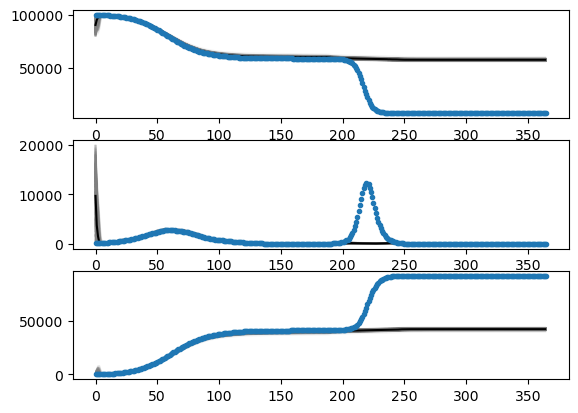

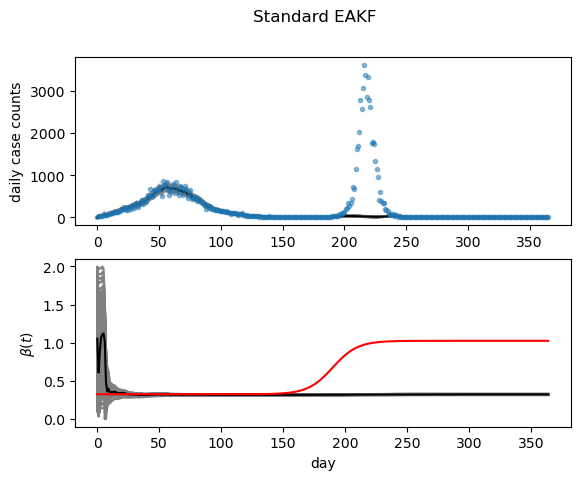

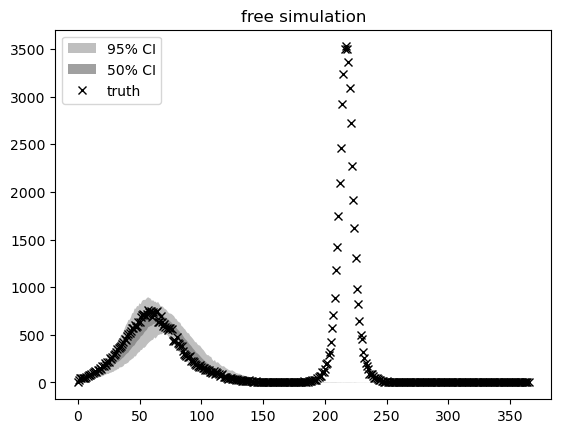

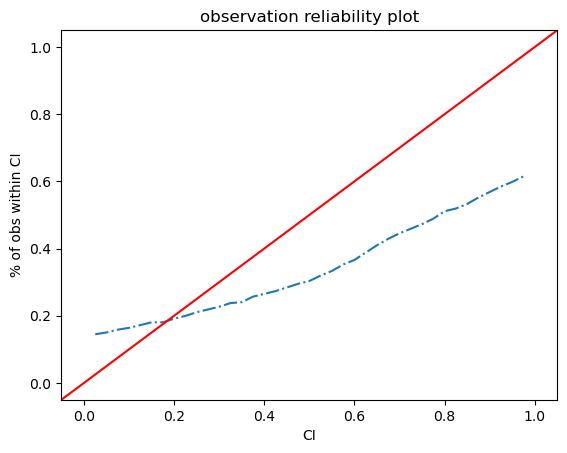

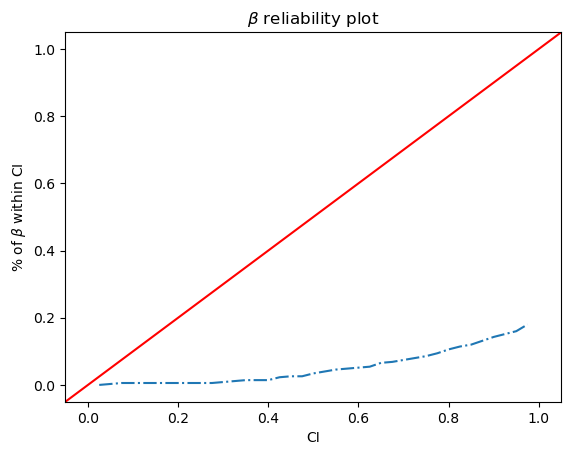

In [23]:
from tqdm import tqdm

x_list = []
θ_list = []
lam_list = []

m = 300

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N, m=m)
        θ = θ0(prior, m=m)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x)           # analysis
        z = data.i[t]
        
        def _adaptive_inflation(x, y, z, oev, lambar_prior=1.01, siglam2=0.1):
            # step 3b
            sig2p = np.var(y)
            ybarp = np.mean(y)
            D = np.abs(ybarp - z)*z/50

            # step 3c
            r = np.cov(x, y)[0,1]  # i
            lam0 = (1. + r*(np.sqrt(lambar_prior) - 1.))**2  # iii
            theta = np.sqrt(lam0 * sig2p + oev)  #iv
            
            
            # v/ Appendix A
            lbar = 1./(np.sqrt(2*np.pi) * theta) * np.exp(-D**2/(2.*theta**2))
            dthetadlam = sig2p * r * (1. - r + r*np.sqrt(lambar_prior))/(2.*theta*np.sqrt(lambar_prior))
            lprime = lbar *(D**2/theta**2 -1.)/theta * dthetadlam
            
            b = lbar/lprime - 2*lambar_prior
            c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
            
            lam1 = np.abs((-b + np.sqrt(b**2 - 4.*c))/2)
            lam2 = np.abs((-b - np.sqrt(b**2 - 4.*c))/2)
            
            if np.abs(lam1 - lambar_prior) < np.abs(lam2 - lambar_prior):
                return lam1
            else:
                return lam2
        
        def _inflate_ensembles(ens, inflation_value, params=False):
            if params:
                _, m = np.asarray(ens).shape
                ens_mean = np.mean(ens, 1, keepdims=True)
                ens_inflated = ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))
            else:
                m = len(ens)
                ens_mean = np.mean(ens)
                ens_inflated = ens_mean * np.ones(m) + inflation_value*(ens - ens_mean*np.ones(m))

            return ens_inflated
        
        
        oev = np.maximum(10, z**2/50)
        # if t > 50:
        #     lam = _adaptive_inflation(θ.beta, y, z, oev)
        #     lam_list.append(lam)
        #     θ = _inflate_ensembles(θ, inflation_value=lam, params=True)
        #     θ = np.clip(θ, 0, 10)
        #     θ = ModelParams(*θ)
        
        x, new_i, alpha = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _, alphaθ = eakf(θ, y, z, oev=oev, m=m)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.2)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.', alpha=0.5)
ax[0].set_ylabel('daily case counts')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('Standard EAKF')

predictions = np.mean([x.i for x in x_list], axis=1)
np.sqrt(((predictions - data.i[:-1]) ** 2).mean())

plot_reliability(θ_list)

### Fixed inflation

Text(0.5, 0.98, 'EAKF full time series inflation 1.03')

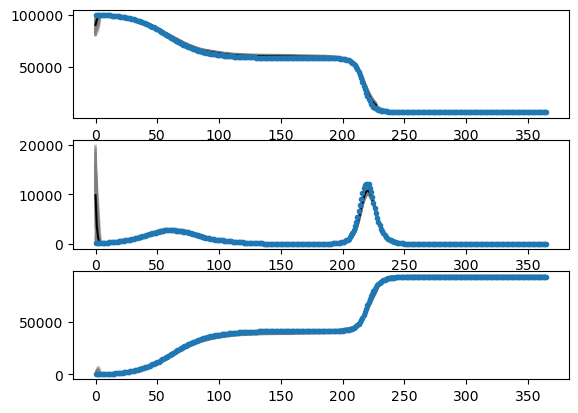

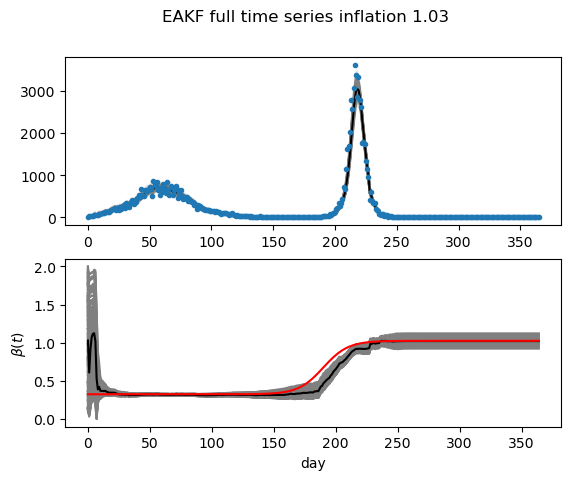

In [92]:
from tqdm import tqdm

x_list = []
θ_list = []
lam_list = []

m = 300

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N, m=m)
        θ = θ0(prior, m=m)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x)           # analysis
        z = data.i[t]
        
        def _inflate_ensembles(ens, inflation_value, params=False):
            if params:
                _, m = np.asarray(ens).shape
                ens_mean = np.mean(ens, 1, keepdims=True)
                ens_inflated = ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))
            else:
                m = len(ens)
                ens_mean = np.mean(ens)
                ens_inflated = ens_mean * np.ones(m) + inflation_value*(ens - ens_mean*np.ones(m))

            return ens_inflated
        
        
        oev = np.maximum(10, z**2/50)
        if t > 50 and t < 250:
            lam = 1.03
            lam_list.append(lam)
            θ = _inflate_ensembles(θ, inflation_value=lam, params=True)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        
        x, new_i, alpha = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _, alpha = eakf(θ, y, z, oev=oev, m=m)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle(f'EAKF full time series inflation {lam}')

Percent of observations in 95% CI 81.42%
Percent of observations in 50% CI 53.01%


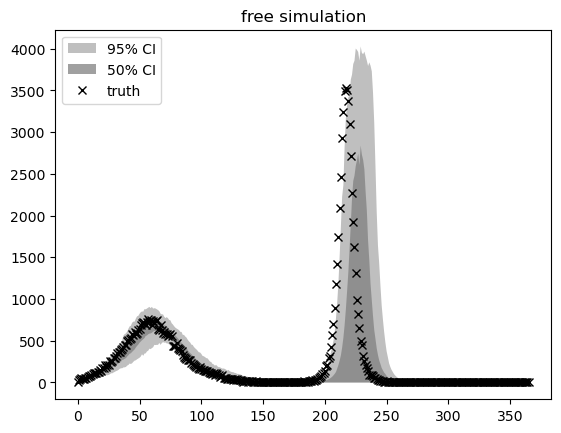

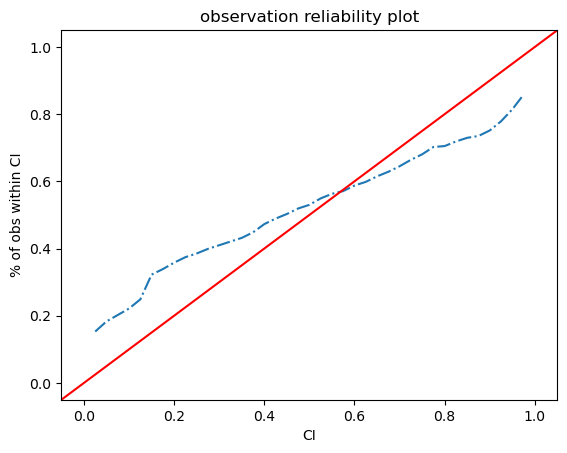

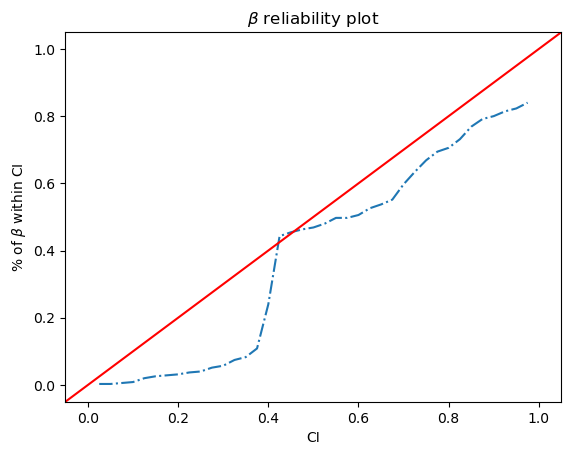

In [91]:
predictions = np.mean([x.i for x in x_list], axis=1)
np.sqrt(((predictions - data.i[:-1]) ** 2).mean())

plot_reliability(θ_list)

# Adaptive Inflation with EnSRS

In [24]:
def ensrf(x, y, z, oev, uhh=True):
    """
    Args:
        xhat: latent states or parameters
        H: observation operator
        y: Hx
        z: observation
        oev: observational error variance
    """
    H = np.array([0,0,0,1])
    x = np.array(x)
    y = np.array(y)

    xbar_hat = np.mean(x, axis=1)
    ybar_hat = np.mean(y)
    
    Pb = np.cov(x)
    Pyy = np.cov(y)
    if uhh:
        K = Pb@H.T/(Pyy + oev)  # eq 2
    else:
        Pb = np.cov(x,y)
        H = np.array([0,0,1])
        K = Pb@H.T/(Pyy + oev)  # eq 2
        K = K[:-1]
    xbar_a = xbar_hat + K*(np.mean(z) - ybar_hat)  # eq 4
    Ktilde = 1/(1 + np.sqrt(oev/(Pyy + oev)))*K    # eq 7
    Ktilde = np.array([Ktilde]).T
    inn = np.array([ybar_hat - y])
    xpost = x - np.array([xbar_hat]).T + np.array([xbar_a]).T + Ktilde@inn  # eq 5
    
    return xpost


In [25]:
# check_again = []
# tol = 2
# day_tol = 50
# for i in tqdm(range(len(better_param_df))):
#     rt0 = better_param_df.iloc[i]['rt_0']
#     rt1 = better_param_df.iloc[i]['rt_1']
#     m = better_param_df.iloc[i]['midpoint']
#     k = better_param_df.iloc[i]['k']
#     d = simulate_data.simulate_data(rt_0 = rt0, rt_1 = rt1, midpoint=m, k=k, n_t = 365, t_I = 4., N = 100_000, S0 = 99_900, I0 = 100, run_deterministic=True)
#     idx, = np.where(np.diff(np.sign(np.diff(d.i_true))) == -2)
#     if np.any([np.diff(d.i_true[id-1:id+1]) < tol for id in idx]):
#         continue
#     if idx[1] - idx[0] < day_tol:
#         continue
#     check_again.append(i)


In [26]:
# check_again_df = better_param_df.iloc[check_again].reset_index()
# check_again_df.to_csv("check_again.csv", index=False)
check_again_df = pd.read_csv("check_again.csv")

In [27]:
check_again_df.head()

,level_0,index,rt_0,rt_1,midpoint,k,n_t,t_I,N,S0,I0
0,773,82284,1.3,2.0,94,0.8,365,4.0,100000.0,99900.0,100.0
1,775,82286,1.3,2.0,95,0.3,365,4.0,100000.0,99900.0,100.0
2,776,82287,1.3,2.0,95,0.4,365,4.0,100000.0,99900.0,100.0
3,777,82288,1.3,2.0,95,0.5,365,4.0,100000.0,99900.0,100.0
4,778,82289,1.3,2.0,95,0.6,365,4.0,100000.0,99900.0,100.0


12591
15005
26551
41523
32965
43811
25303
36002
25283
99957
44185
90911
82024
24501
37755
58744
80126
52517
39803
10068
20469
51244
11120
8202
44822


/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 10))


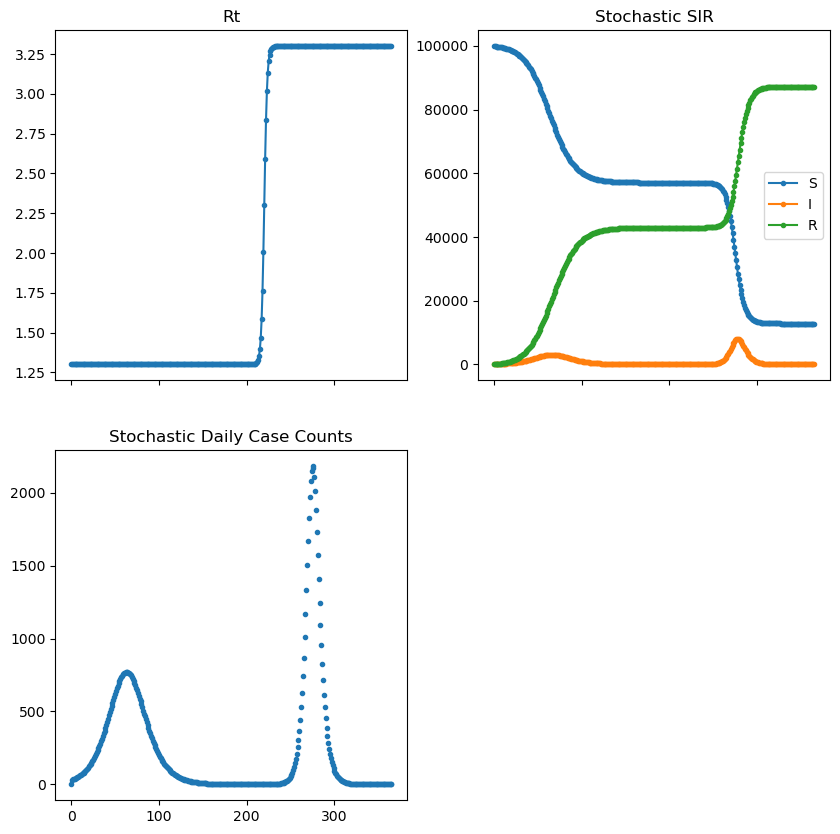

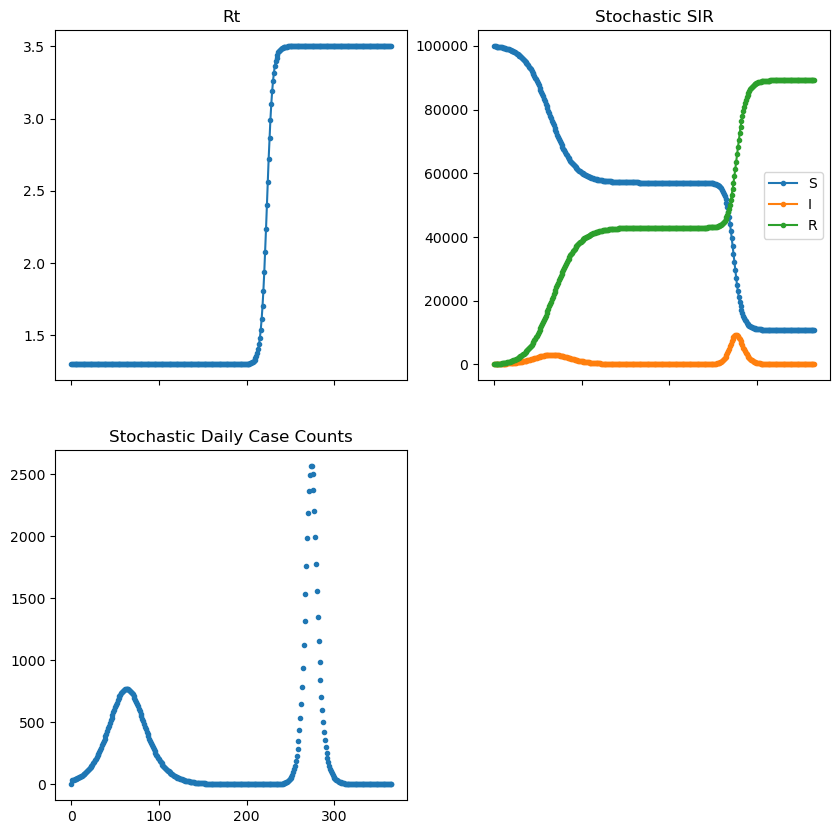

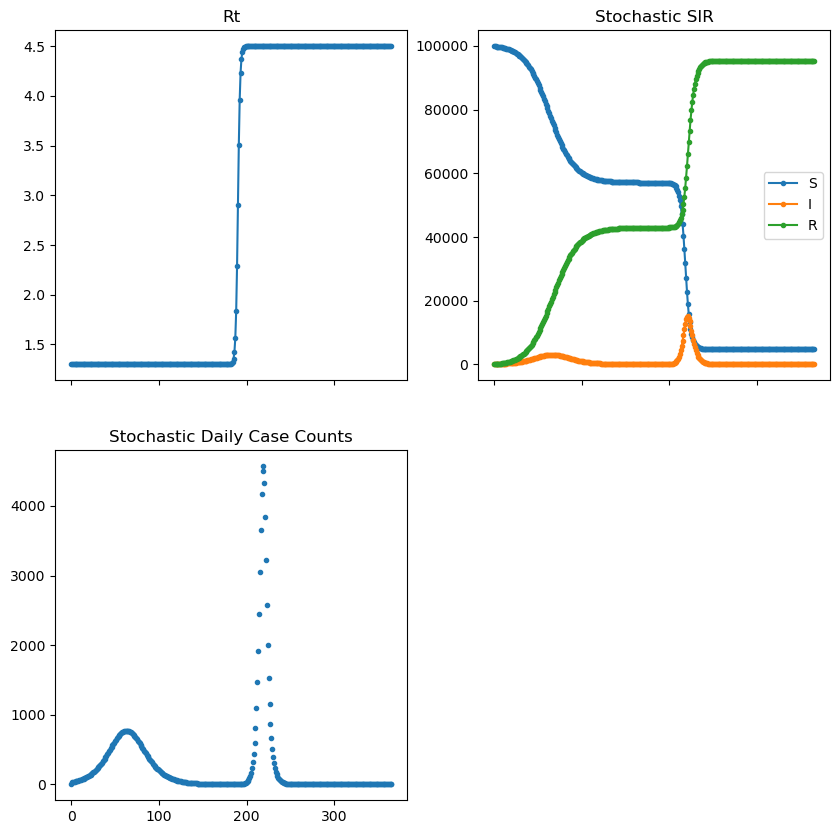

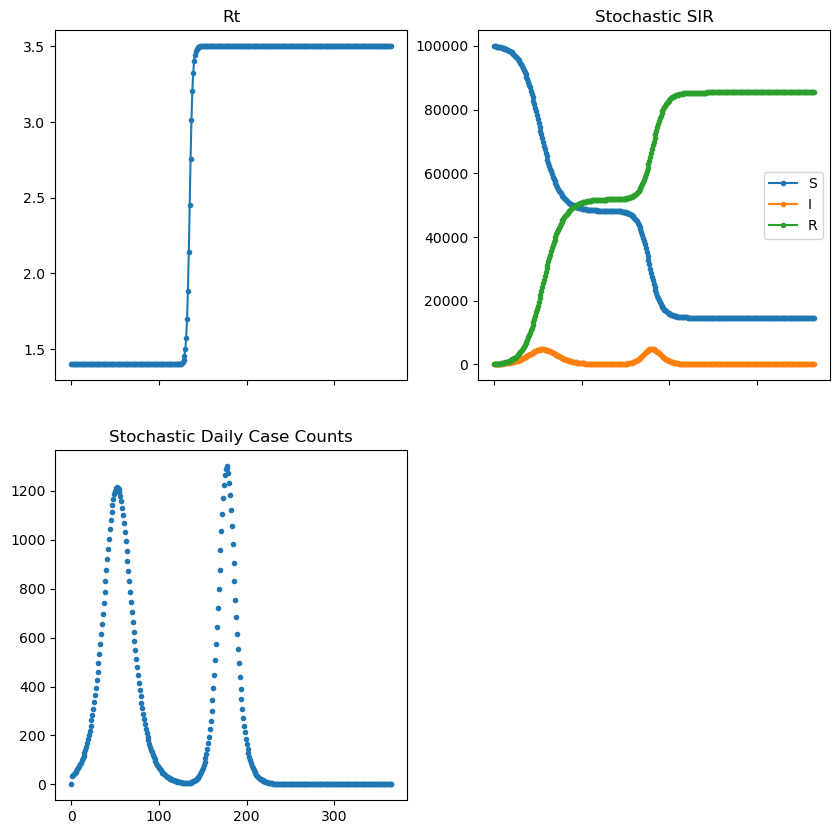

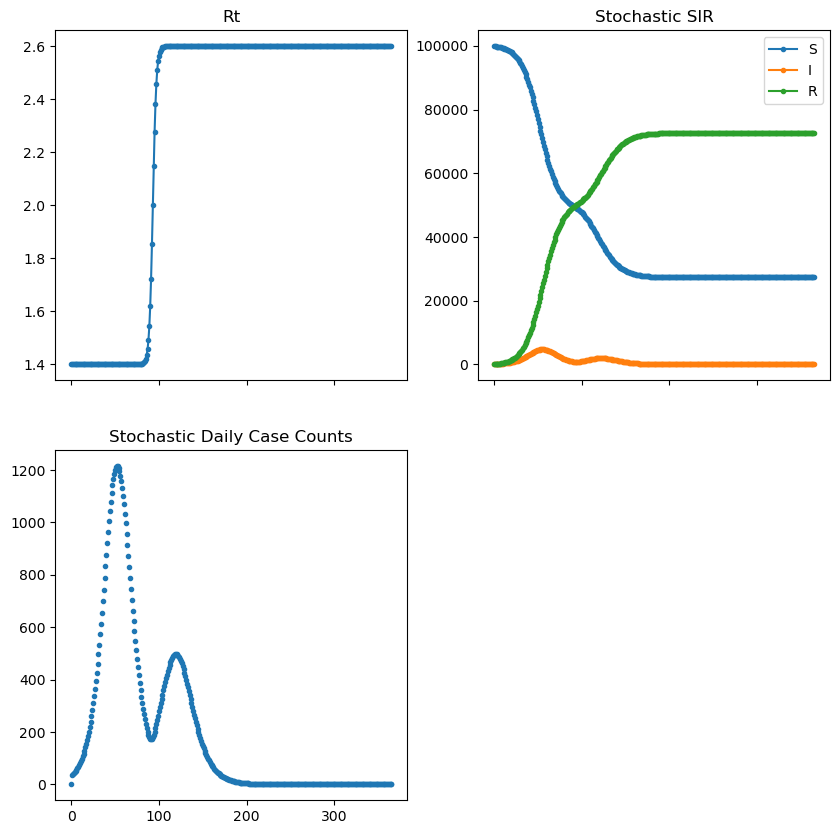

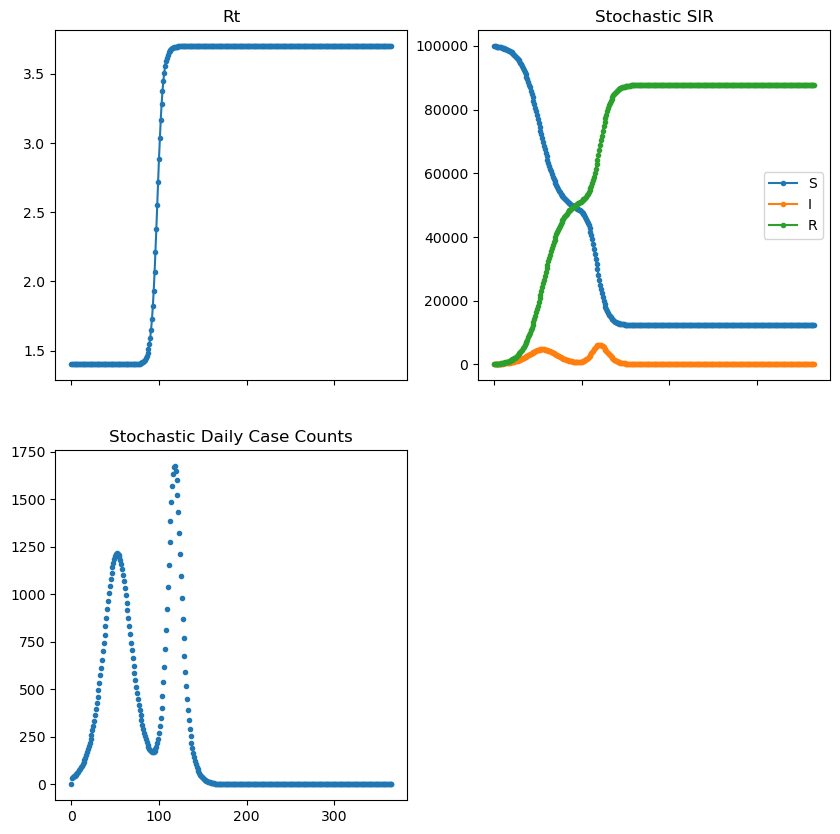

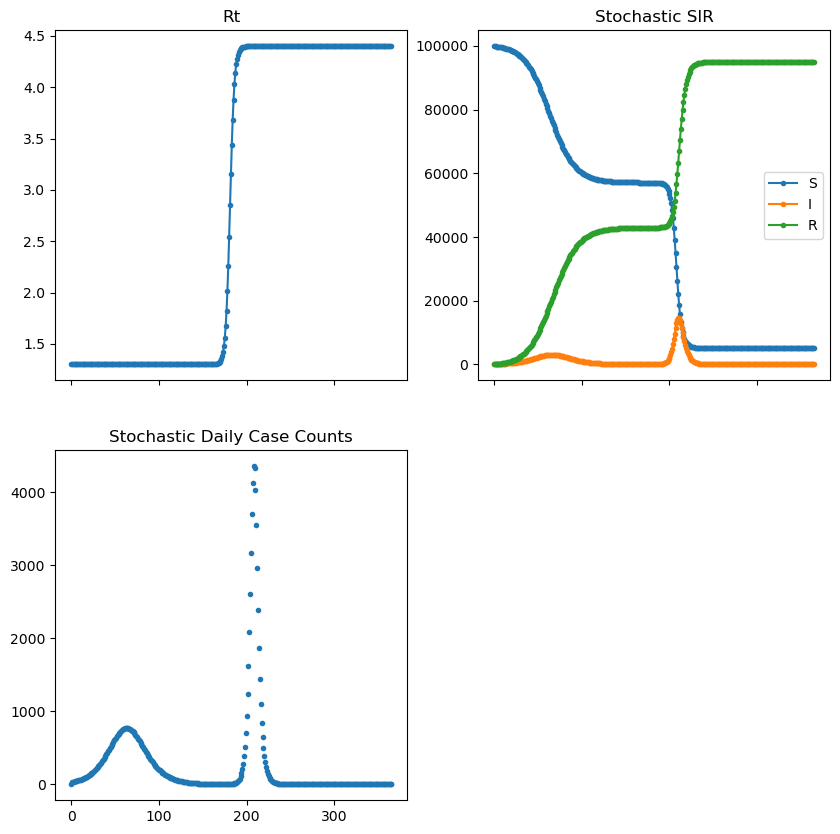

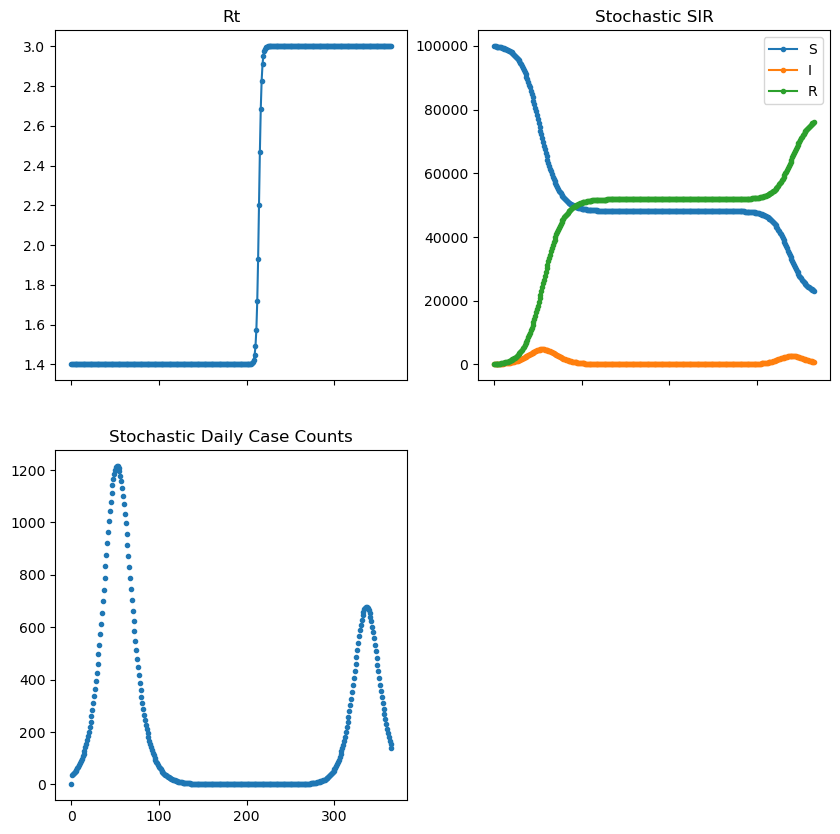

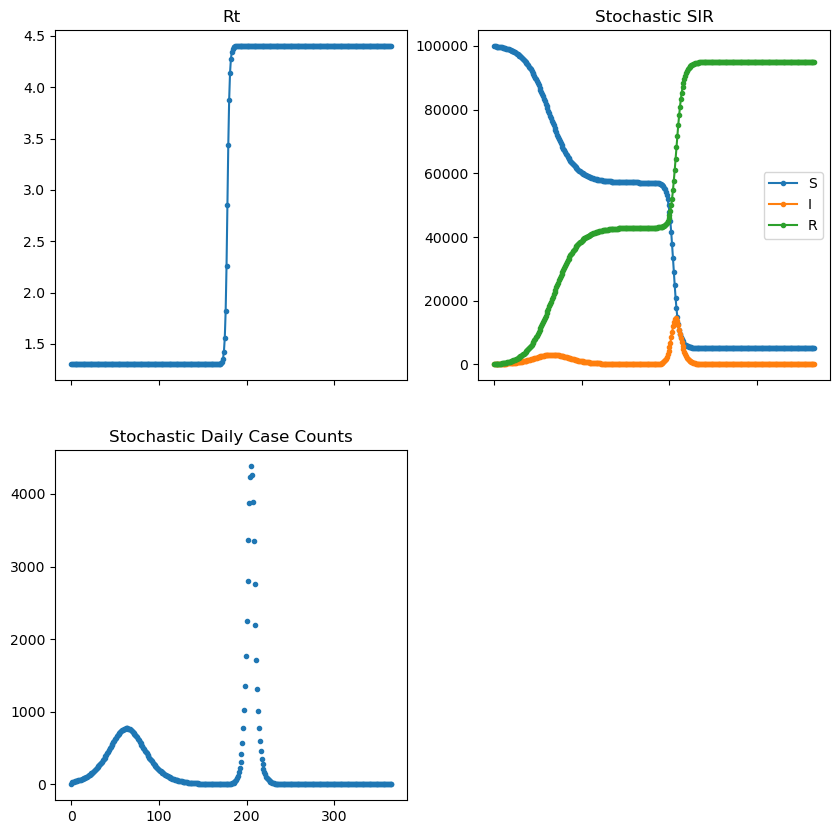

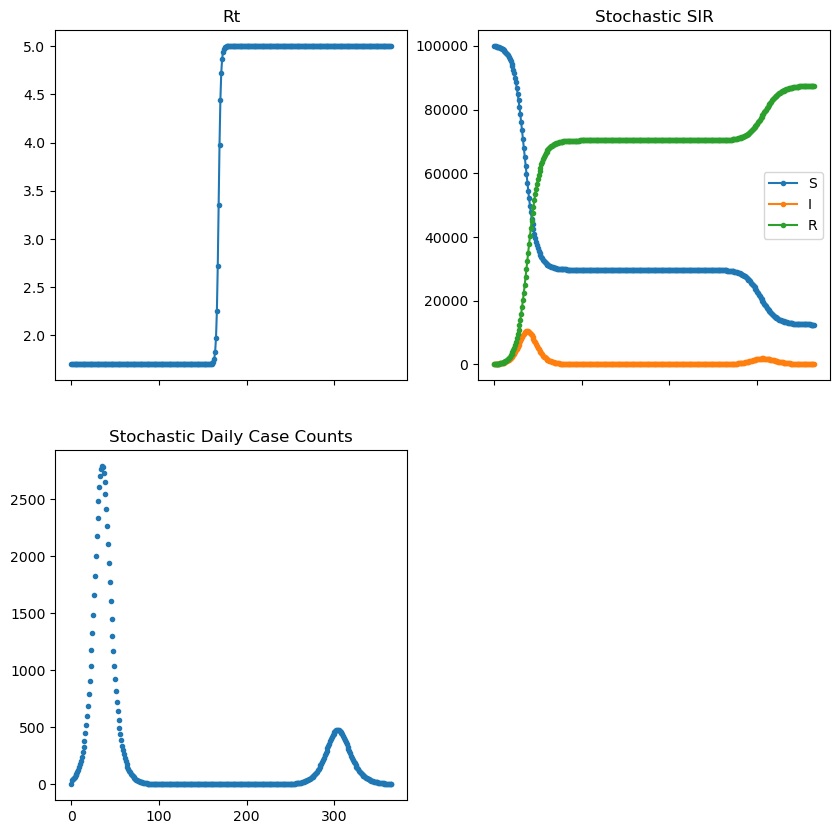

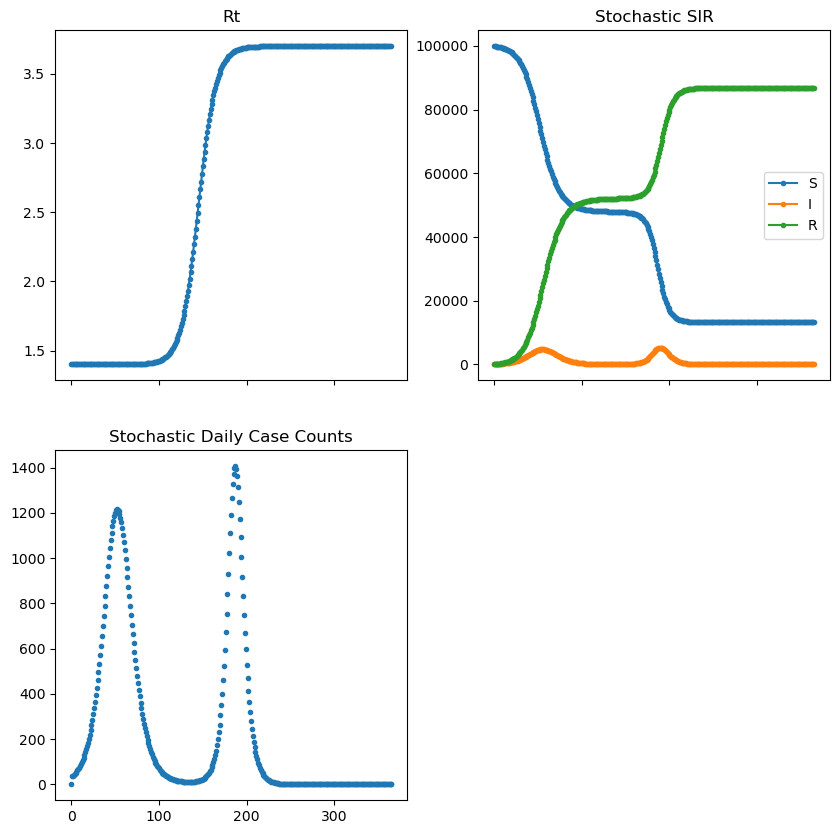

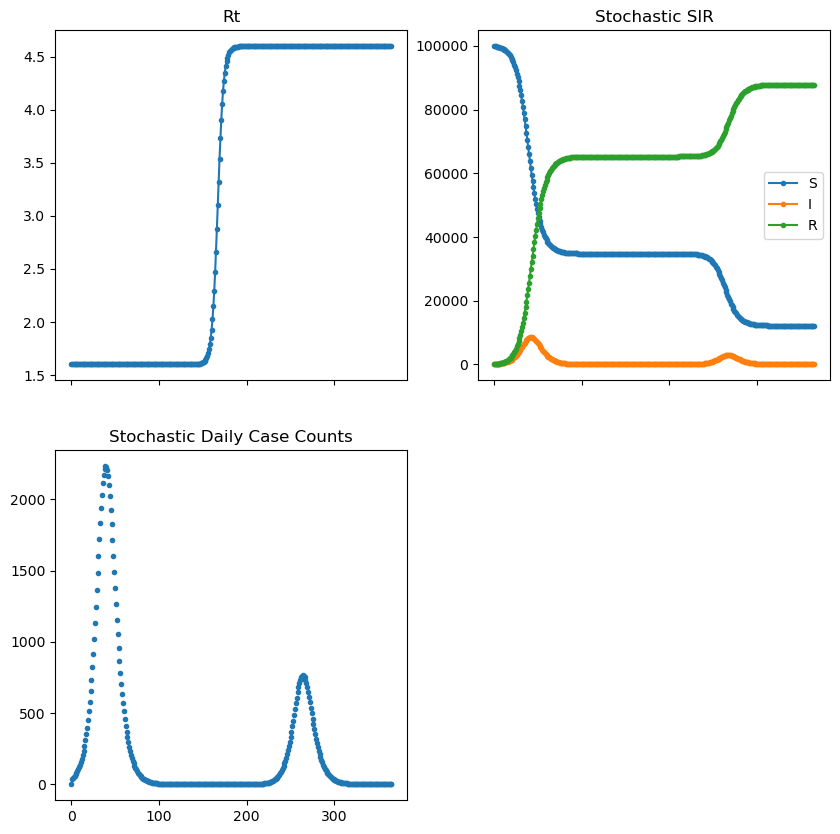

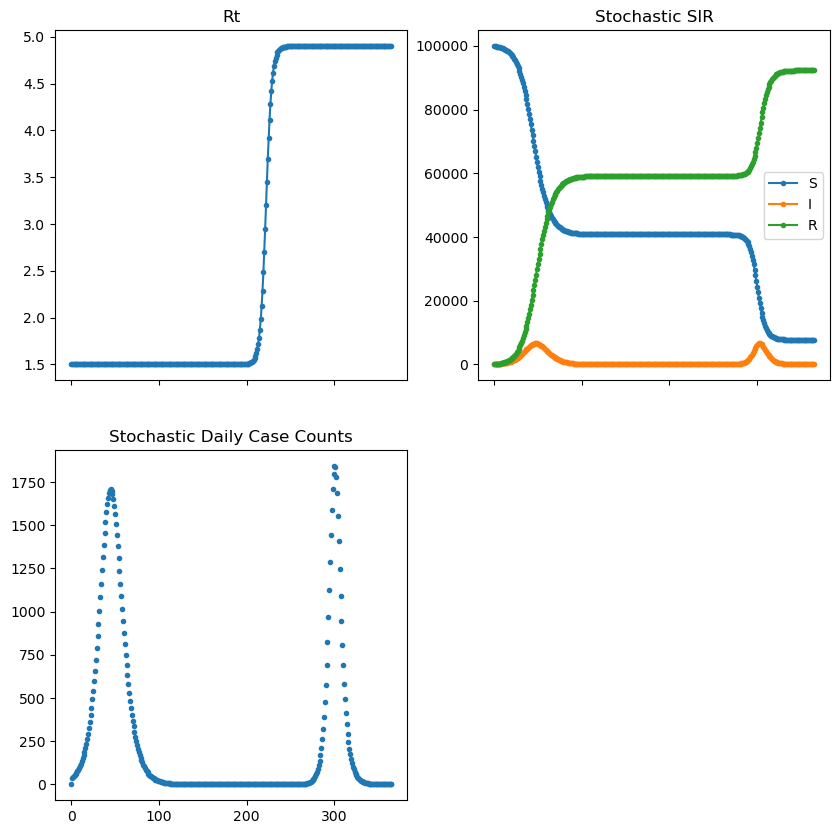

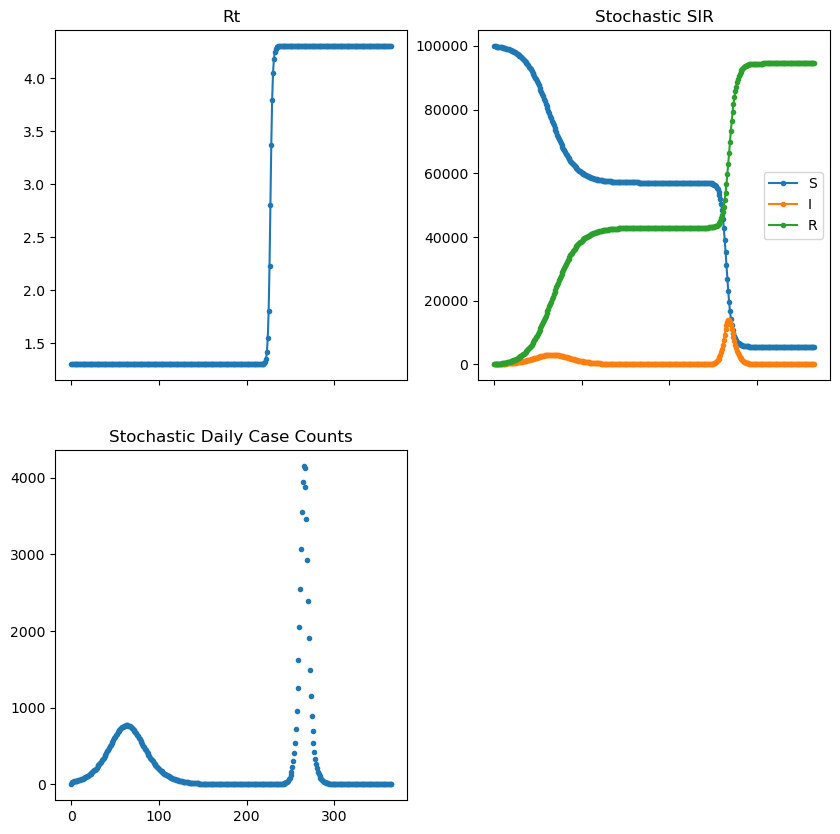

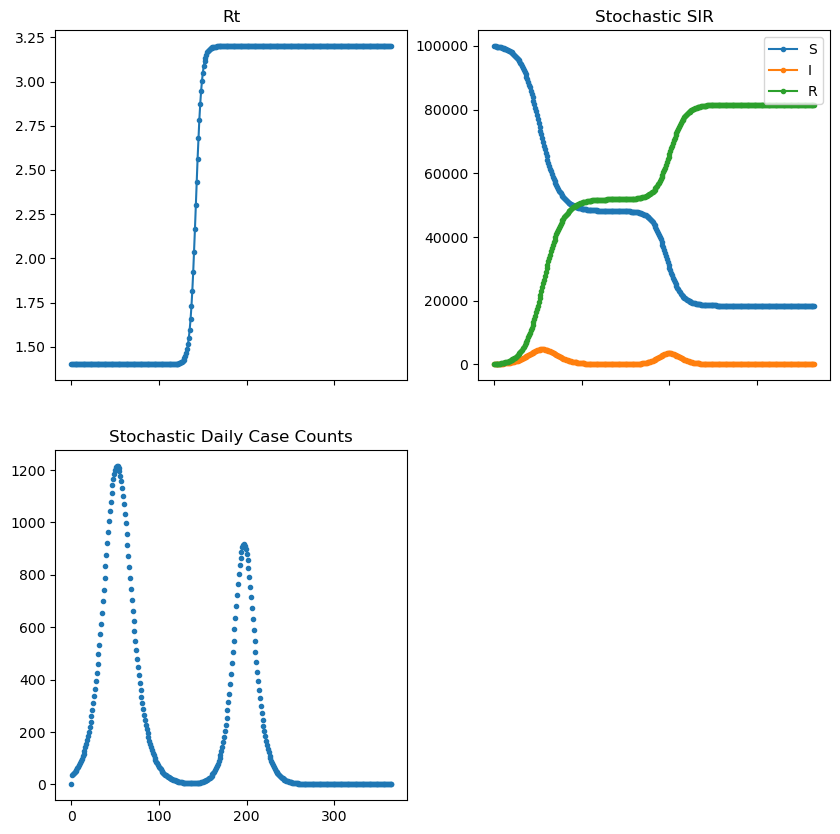

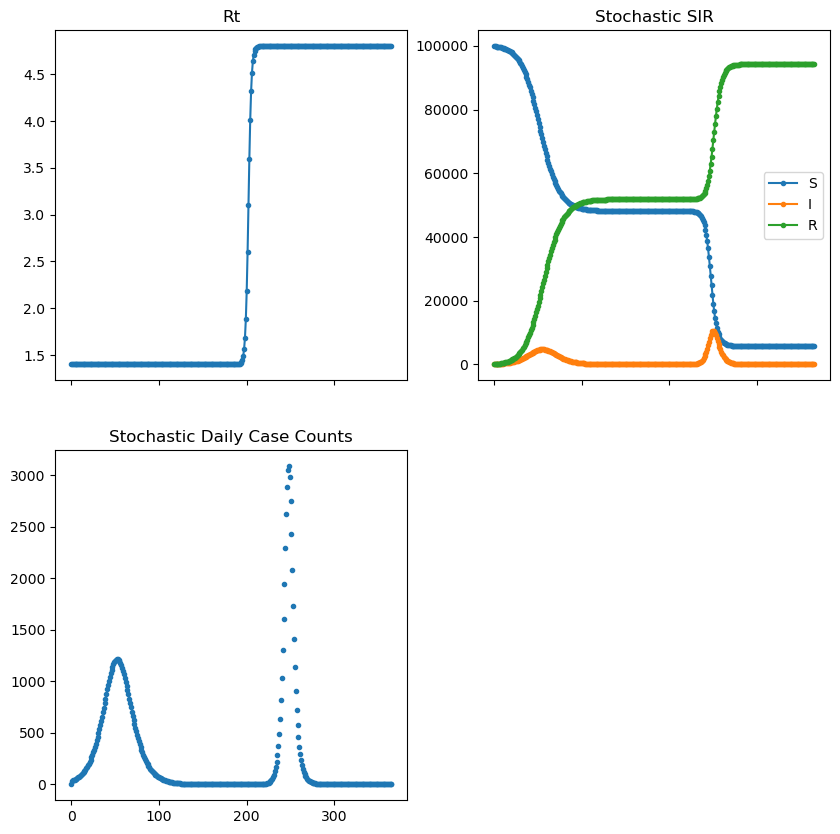

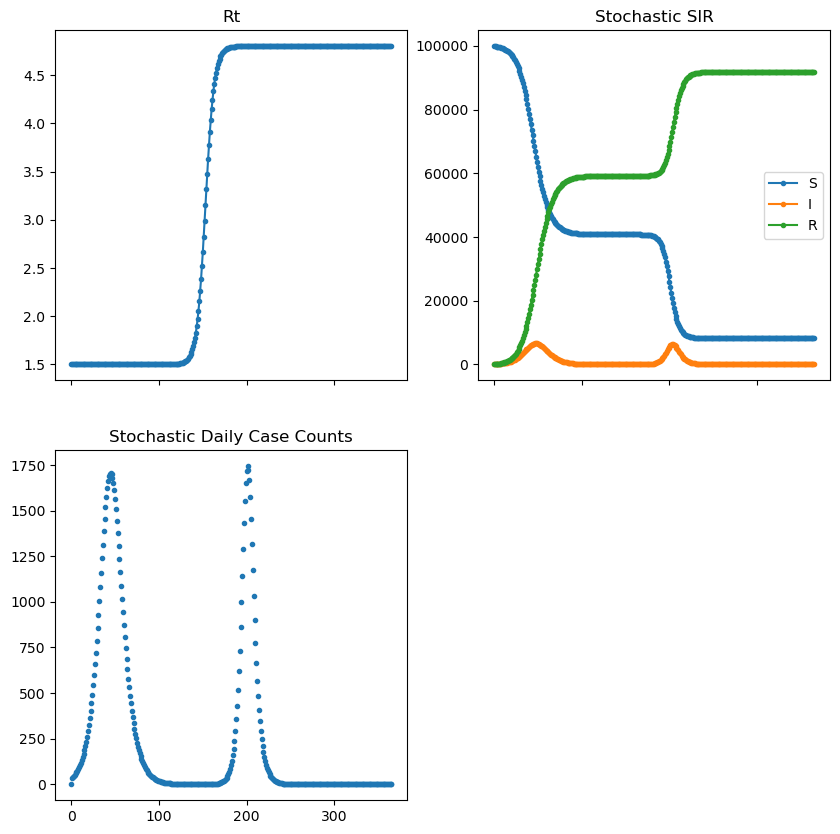

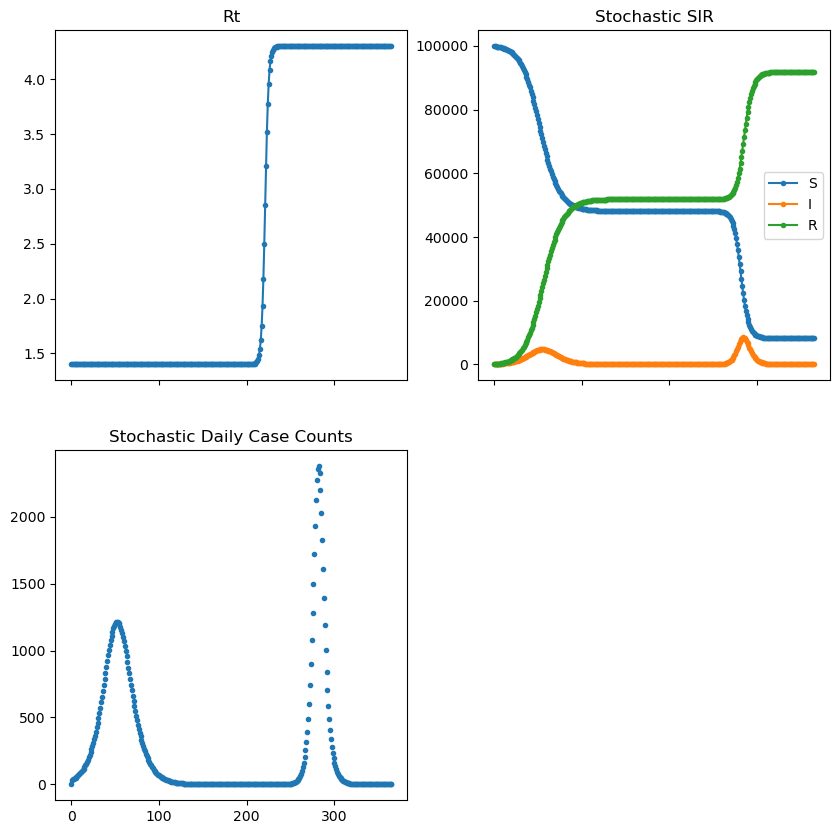

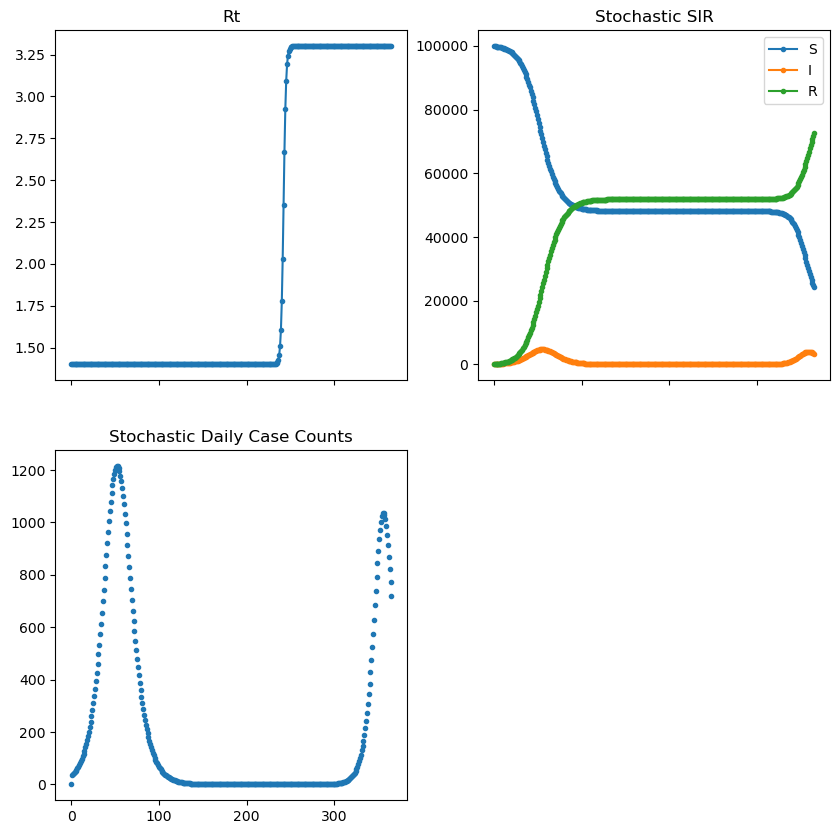

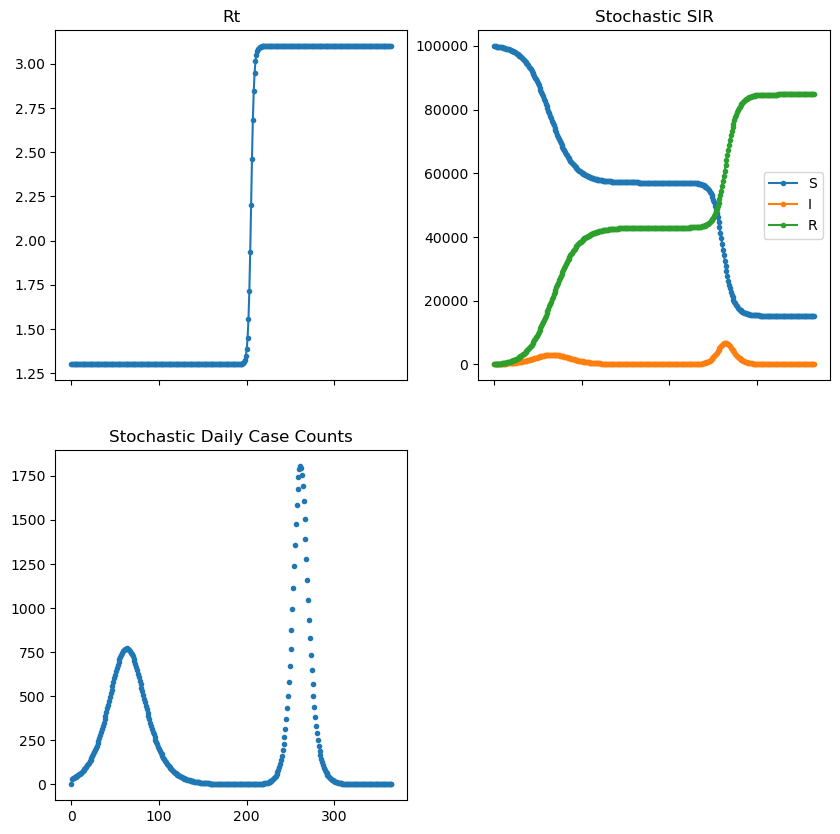

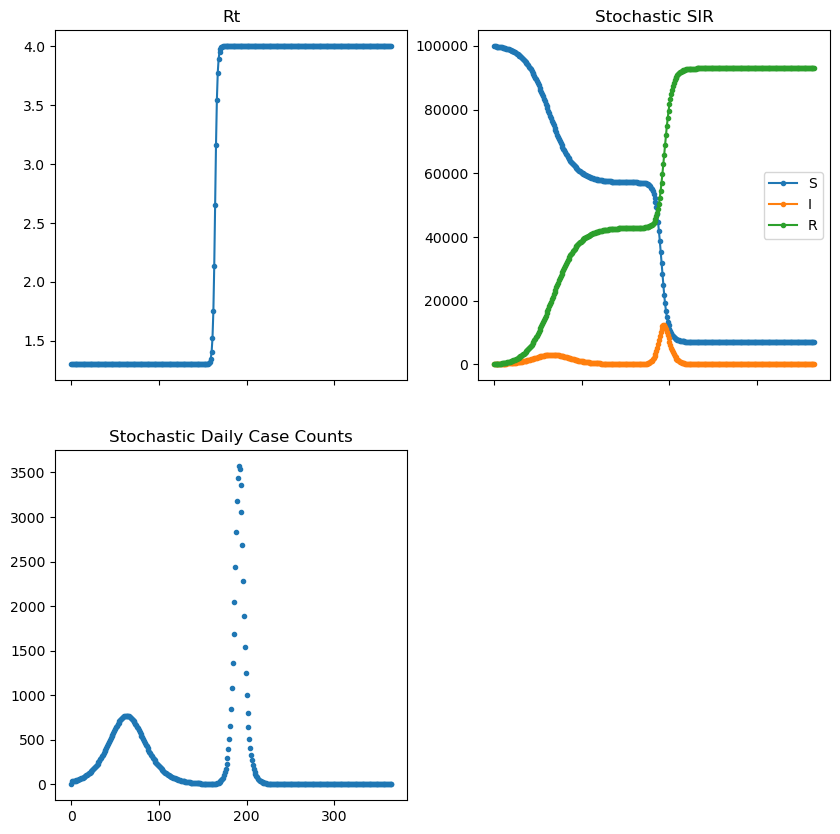

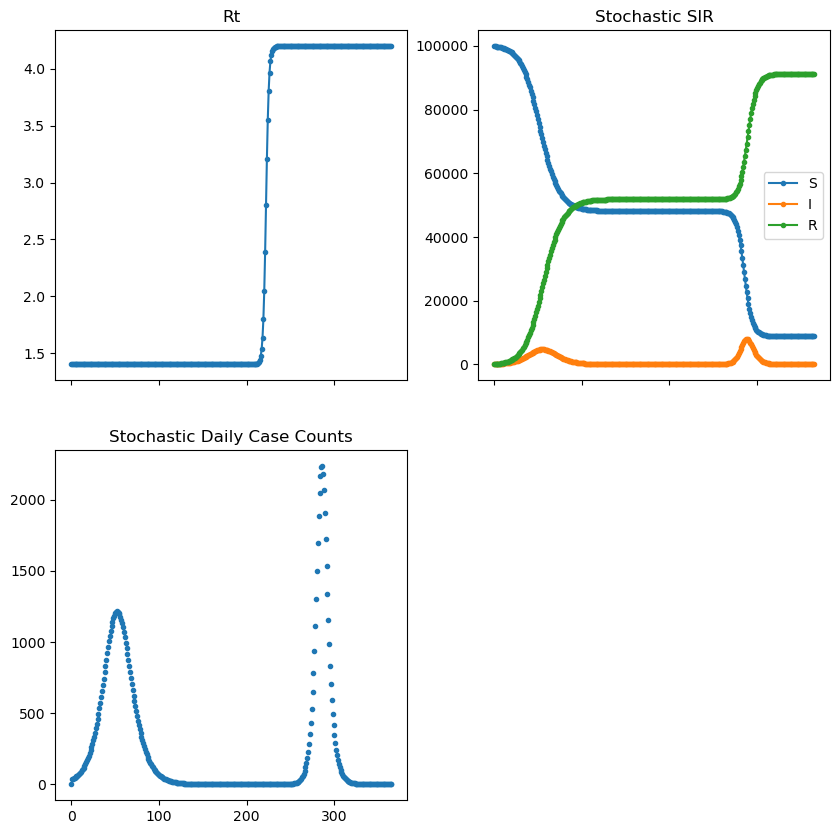

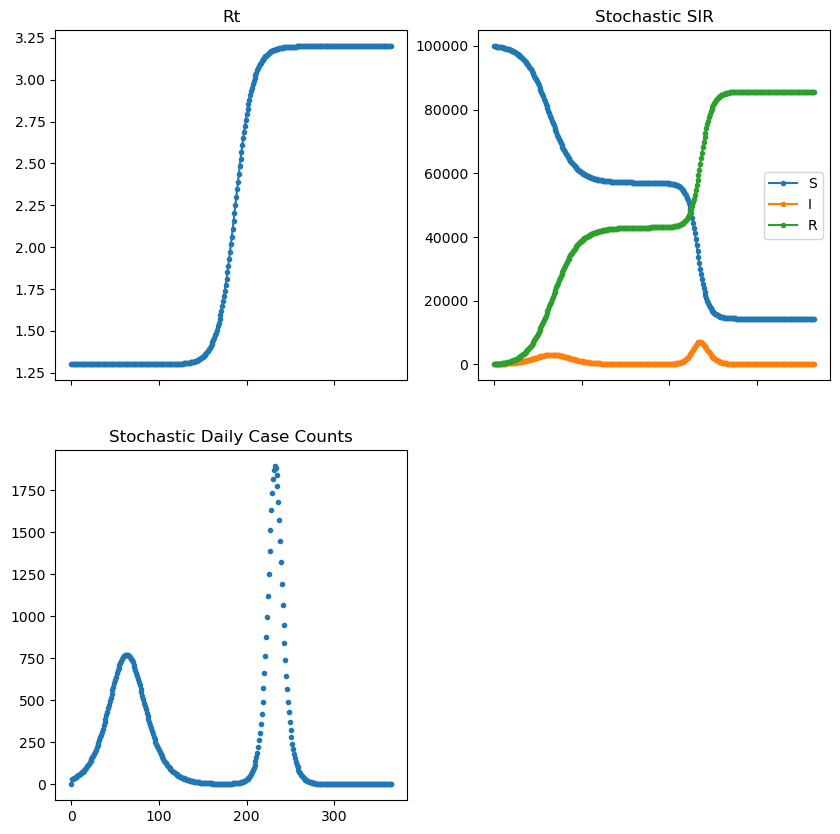

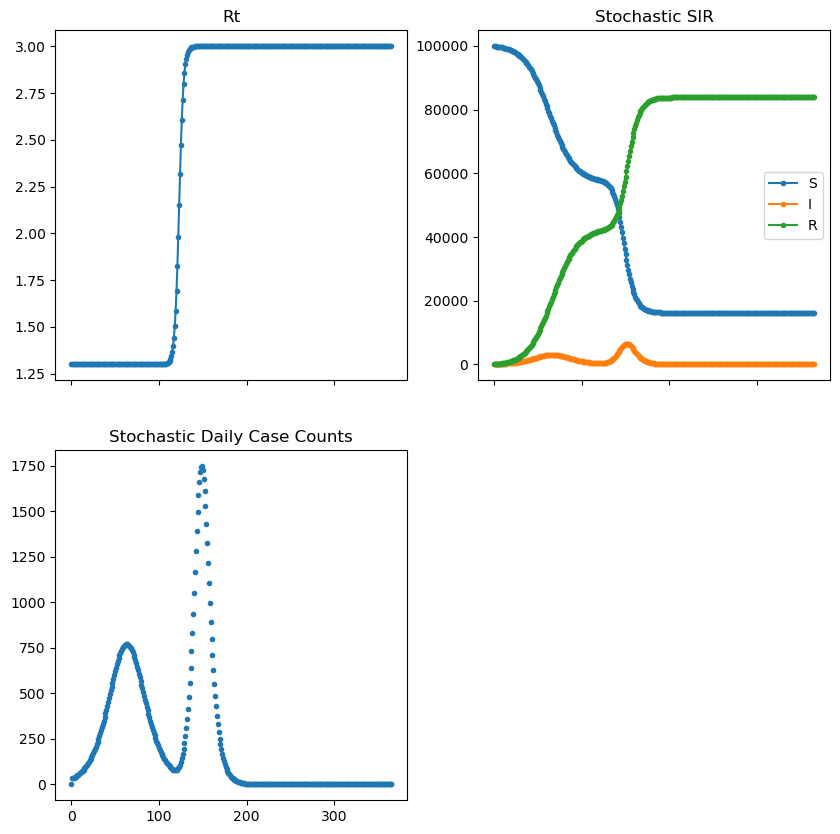

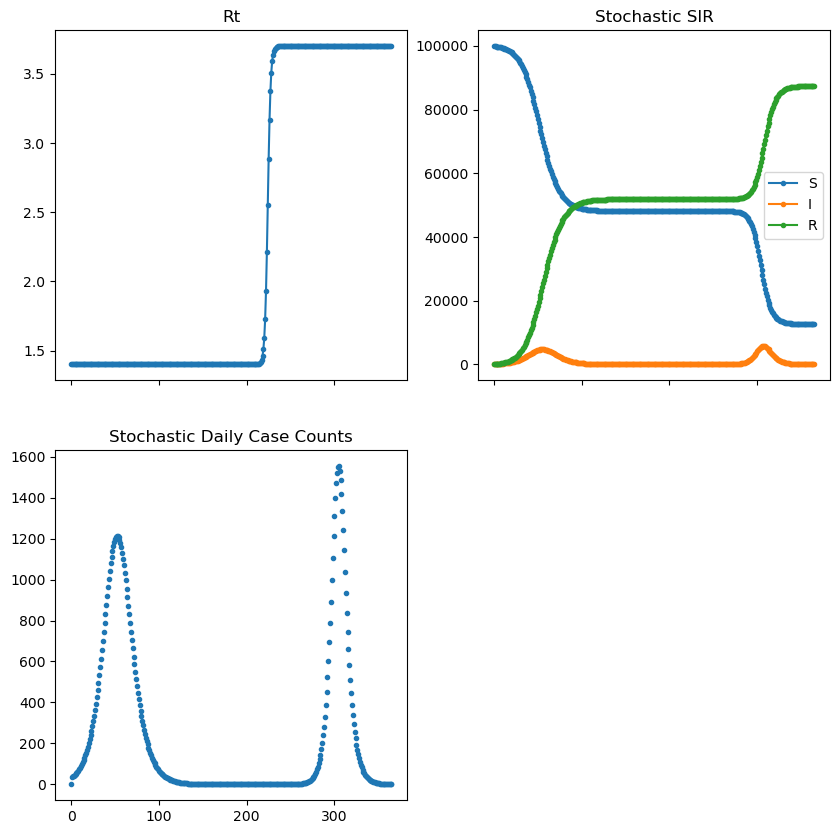

In [28]:
import random
np.random.seed()
param_choices = random.sample(range(0, len(check_again_df)), 25)
for i in param_choices:
    print(i)
    rt0 = check_again_df.iloc[i]['rt_0']
    rt1 = check_again_df.iloc[i]['rt_1']
    m = check_again_df.iloc[i]['midpoint']
    k = check_again_df.iloc[i]['k']
    # d = simulate_data.simulate_data(rt_0 = rt0, rt_1 = rt1, midpoint=m, k=k, n_t = 365, t_I = 4., N = 100_000, S0 = 99_900, I0 = 100, add_noise=True, noise_param=1/50)
    # d.plot_all()
    d = simulate_data.simulate_data(rt_0 = rt0, rt_1 = rt1, midpoint=m, k=k, n_t = 365, t_I = 4., N = 100_000, S0 = 99_900, I0 = 100, run_deterministic=True)
    d.plot_all()


In [37]:
plot = False

from tqdm import tqdm

n_real = 100

early_hist_list = np.array([])
late_hist_list = np.array([])


for i in tqdm(param_choices):
    rt0 = check_again_df.iloc[i]['rt_0']
    rt1 = check_again_df.iloc[i]['rt_1']
    m = check_again_df.iloc[i]['midpoint']
    k = check_again_df.iloc[i]['k']
    data = simulate_data.simulate_data(rt_0 = rt0, rt_1 = rt1, midpoint=m, k=k, n_t = 365, t_I = 4., N = 100_000, S0 = 99_900, I0 = 100, add_noise=True, noise_param=1/50)
    
    early_pt_list = []
    late_pt_list = []

    for _ in range(n_real):
        lam = 1.01
        x_list = []
        xhat_list = []
        θ_list = []
        lam_list = []

        m = 300

        count = 0

        for t, date in enumerate(range(data.n_t)):
            if t == 0:
                x = f0(data.N, m=m)
                θ = θ0(prior, m=m)
                xhat_list.append(x)
            else:
                try:
                    x = f(t, x, θ, data.N)  # prediction
                except:
                    import pdb; pdb.set_trace()
                xhat_list.append(x)
                y = g(x)           # analysis
                z = data.i[t]

                def _adaptive_inflation(x, y, z, oev, lambar_prior=1.01, siglam2=0.001):
                    # step 3b
                    sig2p = np.var(y)
                    ybarp = np.mean(y)
                    D = np.abs(ybarp - z)*z/50

                    # step 3c
                    r = np.cov(x, y)[0,1]  # i
                    lam0 = (1. + r*(np.sqrt(lambar_prior) - 1.))**2  # iii
                    theta = np.sqrt(lam0 * sig2p + oev)  #iv


                    # v/ Appendix A
                    lbar = 1./(np.sqrt(2*np.pi) * theta) * np.exp(-D**2/(2.*theta**2))
                    dthetadlam = sig2p * r * (1. - r + r*np.sqrt(lambar_prior))/(2.*theta*np.sqrt(lambar_prior))
                    lprime = lbar *(D**2/theta**2 -1.)/theta * dthetadlam

                    b = lbar/lprime - 2*lambar_prior
                    c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime

                    lam1 = np.abs((-b + np.sqrt(b**2 - 4.*c))/2)
                    lam2 = np.abs((-b - np.sqrt(b**2 - 4.*c))/2)

                    if np.abs(lam1 - lambar_prior) < np.abs(lam2 - lambar_prior):
                        return lam1
                    else:
                        return lam2

                def _inflate_ensembles(ens, inflation_value, params=False):
                    if params:
                        _, m = np.asarray(ens).shape
                        ens_mean = np.mean(ens, 1, keepdims=True)
                        ens_inflated = ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))
                    else:
                        m = len(ens)
                        ens_mean = np.mean(ens)
                        ens_inflated = ens_mean * np.ones(m) + inflation_value*(ens - ens_mean*np.ones(m))

                    return ens_inflated


                oev = np.maximum(10, z**2/50)
                decay = 0.99
                if t > 10:
                    lam = _adaptive_inflation(θ.beta, y, z, oev, lambar_prior=lam)
                    lam_S = _adaptive_inflation(x.S, y, z, oev)
                    lam_I = _adaptive_inflation(x.I, y, z, oev)
                    lam_R = _adaptive_inflation(x.R, y, z, oev)
                    lam_i = _adaptive_inflation(x.i, y, z, oev)
                    # if z > 0:
                    #     if np.abs(np.mean(y) - z) / z > 1:
                    #         turn_off = True
                    #         lam = 1.
                    #         lam_S = 1.
                    #         lam_I = 1.
                    #         lam_R = 1.
                    #         lam_i = 1.
                    if np.isnan(lam):
                        lam = 1.
                    if np.isnan(lam_S):
                        lam_S = 1.
                    if np.isnan(lam_I):
                        lam_I = 1.
                    if np.isnan(lam_R):
                        lam_R = 1.
                    if np.isnan(lam_i):
                        lam_i = 1.
                    # if turn_off:
                    #     lam = 1.
                    # if t > 250:
                    #     lam = 1.
                    lam_list.append(lam)
                    θ = _inflate_ensembles(θ, inflation_value=lam, params=True)
                    θ = np.clip(θ, 0, 10)
                    # print(lam)
                    θ = ModelParams(*θ)

                    # print(lam_S, lam_I, lam_R)
                    S = _inflate_ensembles(x.S, inflation_value=lam_S)
                    I = _inflate_ensembles(x.I, inflation_value=lam_I)
                    R = _inflate_ensembles(x.R, inflation_value=lam_R)
                    i = _inflate_ensembles(x.i, inflation_value=lam_i)

                    x = SIR(
                        S = np.clip(S, 0, data.N),
                        I = np.clip(I, 0, data.N),
                        R = np.clip(R, 0, data.N),
                        i = np.clip(i, 0, data.N)
                    )

                x, new_i, alpha = eakf(x, y, z, oev=oev)
                x = SIR(*x)
                x = x._replace(i=new_i)
                x = SIR(
                    S = np.clip(x.S, 0, data.N),
                    I = np.clip(x.I, 0, data.N),
                    R = np.clip(x.R, 0, data.N),
                    i = np.clip(x.i, 0, data.N)
                )
                θ, _, alphaθ = eakf(θ, y, z, oev=oev, m=m)
                θ = np.clip(θ, 0, None)
                θ = ModelParams(*θ)

            x_list.append(x)
            θ_list.append(θ)

        if plot:
            fig, ax = plt.subplots(3)
            ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
            ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
            ax[0].plot(data.S, '.')

            ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
            ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
            ax[1].plot(data.I, '.')

            ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
            ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
            ax[2].plot(data.R, '.')

            fig, ax = plt.subplots(2)
            ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
            ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
            ax[0].plot(data.i, '.')

            ax[1].plot([θ.beta for θ in θ_list], color="gray")
            ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
            ax[1].plot(beta, color="red")
            ax[1].set_xlabel('day')
            ax[1].set_ylabel(r'$\beta(t)$')

            fig.suptitle('EAKF full time series adaptive inflation')

            plt.plot(lam_list)
            plt.xlabel("day")
            plt.ylabel(r"$\lambda$ inflation")

        l = 1

        x_list = np.array(x_list)
        xhat_list = np.array(xhat_list)
        θ_list = np.array(θ_list)

        x_lag_list = []
        θ_lag_list = []

        for k in range(data.n_t-1):
            z = data.i[k+l]
            oev = np.maximum(10, z**2/50)
            H = np.array([0,0,0,1])

            ## Smooth STATES
            x = x_list[k,:,:]
            xhat = xhat_list[k+l,:,:]

            y = H@xhat
            ybar_hat = np.mean(y)
            Pyy = np.cov(y)
            Pb = np.cov(xhat)
            Pba = np.cov(x, xhat)[4:,4:]
            # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
            # eq 9
            K_lag = (H@Pba).T/(Pyy+oev)

            x_bar = np.mean(x, axis=1)
            xhat_bar = np.array([np.mean(xhat, axis=1)])
            # eq 8
            xbar_lag = x_bar + K_lag*(z - ybar_hat)
            # eq 15
            Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
            # eq 13
            x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)

            x_lag = np.clip(x_lag, 0, data.N)
            x_lag = SIR(*x_lag)
            x_lag_list.append(x_lag)


            ## Smooth PARAMS
            θ = θ_list[k,:,:]
            Pb = np.cov(θ,y)
            H = np.array([0,0,1])
            Pba = np.cov(θ,y)

            # eq 9
            K_lag = (H@Pba).T/(Pyy+oev)
            K_lag = K_lag[:-1]

            θ_bar = np.array([np.mean(θ, axis=1)]).T
            θhat_bar = θ_bar
            # eq 8
            θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
            # eq 15
            Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
            # eq 13
            θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])

            θ_lag = np.clip(θ_lag, 0, 10)
            θ_lag = ModelParams(*θ_lag)
            θ_lag_list.append(θ_lag)

        # plot
        if plot:
            x_lag_list = np.array(x_lag_list)
            x_lag_means = np.mean(x_lag_list, axis=2)

            fig, ax = plt.subplots(3)
            ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
            ax[0].plot(x_lag_means[:,0], color='black')
            ax[0].plot(data.S, '.')

            ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
            ax[1].plot(x_lag_means[:,1], color='black')
            ax[1].plot(data.I, '.')

            ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
            ax[2].plot(x_lag_means[:,2], color='black')
            ax[2].plot(data.R, '.')

        fθ_lag_list = np.array(θ_lag_list)

        θ_lag_list = np.array(θ_lag_list)

        if plot:
            fig, ax = plt.subplots(2)

            ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
            ax[0].plot(data.i, '.')
            ax[0].plot(x_lag_means[:,3], color='black')
            ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

            ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
            ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
            ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
            # ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
            ax[1].set_xlabel('day')
            ax[1].set_ylabel(r'$\beta(t)$')

            fig.suptitle(f'EnSRS window size {l} with adaptive inflation')

        for l in np.arange(2,10):

            θ_list = np.array(θ_lag_list).copy()
            x_list = np.array(x_lag_list).copy()

            x_lag_list = []
            θ_lag_list = []

            for k in range(data.n_t-l):
                z = data.i[k+l]
                oev = np.maximum(10, z**2/50)
                H = np.array([0,0,0,1])

                ## Smooth STATES
                x = x_list[k,:,:]
                xhat = xhat_list[k+l,:,:]

                y = H@xhat
                ybar_hat = np.mean(y)
                Pyy = np.cov(y)
                Pb = np.cov(xhat)
                Pba = np.cov(x, xhat)[4:,4:]
                # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
                # eq 9
                K_lag = (H@Pba).T/(Pyy+oev)

                x_bar = np.mean(x, axis=1)
                xhat_bar = np.array([np.mean(xhat, axis=1)])
                # eq 8
                xbar_lag = x_bar + K_lag*(z - ybar_hat)
                # eq 15
                Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
                # eq 13
                x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)

                x_lag = np.clip(x_lag, 0, data.N)
                x_lag = SIR(*x_lag)
                x_lag_list.append(x_lag)


                ## Smooth PARAMS
                θ = θ_list[k,:,:]
                Pb = np.cov(θ,y)
                H = np.array([0,0,1])
                Pba = np.cov(θ,y)

                # eq 9
                K_lag = (H@Pba).T/(Pyy+oev)
                K_lag = K_lag[:-1]

                θ_bar = np.array([np.mean(θ, axis=1)]).T
                θhat_bar = θ_bar
                # eq 8
                θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
                # eq 15
                Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
                # eq 13
                θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])

                θ_lag = np.clip(θ_lag, 0, 10)
                θ_lag = ModelParams(*θ_lag)
                θ_lag_list.append(θ_lag)

            # plot
            if plot:
                x_lag_list = np.array(x_lag_list)
                x_lag_means = np.mean(x_lag_list, axis=2)

                fig, ax = plt.subplots(3)
                ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
                ax[0].plot(x_lag_means[:,0], color='black')
                ax[0].plot(data.S, '.')

                ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
                ax[1].plot(x_lag_means[:,1], color='black')
                ax[1].plot(data.I, '.')

                ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
                ax[2].plot(x_lag_means[:,2], color='black')
                ax[2].plot(data.R, '.')

            fθ_lag_list = np.array(θ_lag_list)

            θ_lag_list = np.array(θ_lag_list)

            if plot:
                fig, ax = plt.subplots(2)

                ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
                ax[0].plot(data.i, '.')
                ax[0].plot(x_lag_means[:,3], color='black')
                # ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

                ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
                ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
                ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
                # ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
                ax[1].set_xlabel('day')
                ax[1].set_ylabel(r'$\beta(t)$')

                fig.suptitle(f'EnSRS window size {l} with adaptive inflation')
        
        beta_0 = data.rt_0 / data.t_I
        beta_1 = data.rt_1 / data.t_I
        early_day = -1/data.k * np.log((beta_1 - beta_0)/(1.01*beta_0 - beta_0)-1) + data.midpoint
        # import pdb; pdb.set_trace()
        late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
        early_post = θ_lag_list[int(early_day),0,:]
        early_truth = data.construct_beta(data.rt, data.t_I)[int(early_day)]
        late_post = θ_lag_list[int(late_day),0,:]
        late_truth = data.construct_beta(data.rt, data.t_I)[int(late_day)]
        early_quantiles = np.percentile(early_post, np.linspace(0,100,100))
        if np.any(np.where(early_quantiles < early_truth)):
            early_pt = np.max(np.where(early_quantiles < early_truth))
        else:
            early_pt = 1
        early_pt_list.append(early_pt)
        
        late_quantiles = np.percentile(late_post, np.linspace(0,100,100))
        if np.any(np.where(late_quantiles < late_truth)):
            late_pt = np.max(np.where(late_quantiles < late_truth))
        else:
            late_pt = 1
        late_pt_list.append(late_pt)
    if np.any(early_hist_list):
        early_hist_list = np.vstack([early_hist_list, np.array(early_pt_list)])
    else:
        early_hist_list = np.array(early_pt_list)
        
    if np.any(late_hist_list):
        late_hist_list = np.vstack([late_hist_list, np.array(late_pt_list)])
    else:
        late_hist_list = np.array(late_pt_list)

  4%|████▍                                                                                                           | 1/25 [01:30<36:20, 90.85s/it]/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_4059/2027586304.py:63: RuntimeWarning: invalid value encountered in double_scalars
  b = lbar/lprime - 2*lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_4059/2027586304.py:64: RuntimeWarning: invalid value encountered in double_scalars
  c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
 36%|████████████████████████████████████████▎                                                                       | 9/25 [13:37<24:10, 90.64s/it]/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_4059/2027586304.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  b = lbar/lprime - 2*lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_4059/2027586304.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  c

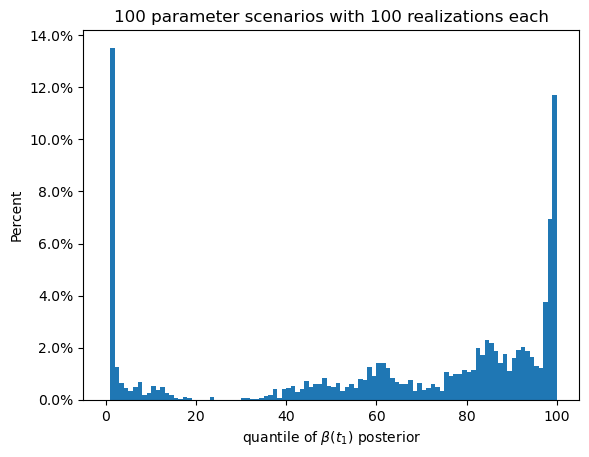

In [38]:
from matplotlib.ticker import PercentFormatter

plt.title(f"100 parameter scenarios with {n_real} realizations each")
plt.ylabel("Percent")
plt.xlabel(r"quantile of $\beta(t_1)$ posterior")
_ = plt.hist(early_hist_list.flatten(), weights=np.ones(len(early_hist_list.flatten())) / len(early_hist_list.flatten()), range=(0,100), bins=100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

$$
t_1 = -\frac{1}{k} \log\left(\frac{\beta_1 - \beta_0}{1.01\beta_0 - \beta_0}-1\right) + m
$$

$$
t_2 = -\frac{1}{k} \log\left(\frac{\beta_1 - \beta_0}{0.99\beta_1 - \beta_0}-1\right) + m
$$

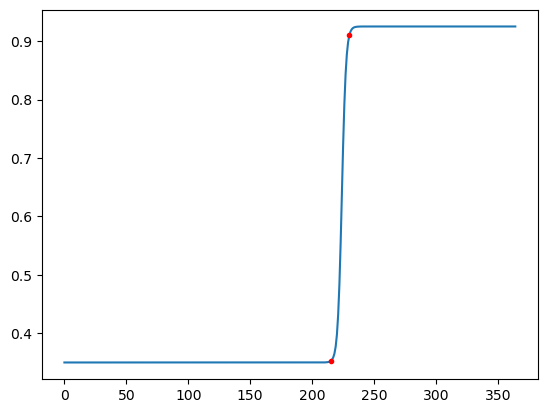

In [39]:
beta = data.construct_beta(data.rt, data.t_I)

fig, ax = plt.subplots()
ax.plot(beta)
ax.plot(int(early_day), beta[int(early_day)], '.', color='red')
ax.plot(int(late_day), beta[int(late_day)], '.', color='red')

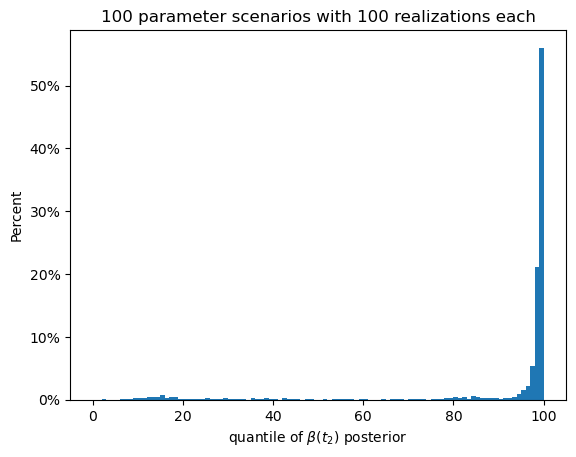

In [40]:
plt.title(f"100 parameter scenarios with {n_real} realizations each")
plt.ylabel("Percent")
plt.xlabel(r"quantile of $\beta(t_2)$ posterior")
_ = plt.hist(late_hist_list.flatten(), weights=np.ones(len(late_hist_list.flatten())) / len(late_hist_list.flatten()), range=(0,100), bins=100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Text(0.5, 0.98, 'EnSRS window size 9 with adaptive inflation')

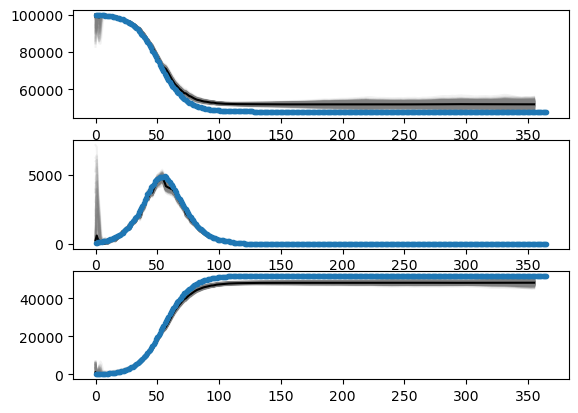

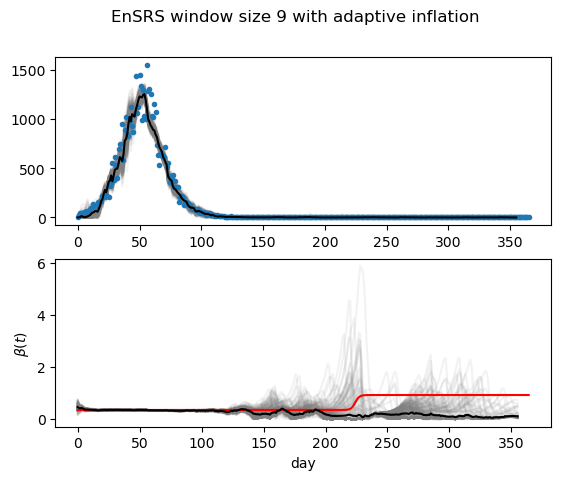

In [41]:

x_lag_list = np.array(x_lag_list)
x_lag_means = np.mean(x_lag_list, axis=2)

fig, ax = plt.subplots(3)
ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
ax[0].plot(x_lag_means[:,0], color='black')
ax[0].plot(data.S, '.')

ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
ax[1].plot(x_lag_means[:,1], color='black')
ax[1].plot(data.I, '.')

ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
ax[2].plot(x_lag_means[:,2], color='black')
ax[2].plot(data.R, '.')

fθ_lag_list = np.array(θ_lag_list)

θ_lag_list = np.array(θ_lag_list)


fig, ax = plt.subplots(2)

ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(x_lag_means[:,3], color='black')
# ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
# ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle(f'EnSRS window size {l} with adaptive inflation')

# Infer Sigmoid Parameters

In [59]:
SigmoidModelParams = collections.namedtuple(
    typename='SigmoidModelParams',
    field_names=[
        'beta_0',
        'beta_1',
        'midpoint',
        'k'
    ]
)

def clip_sigmoid_params(θ):
    return SigmoidModelParams(
        beta_0 = np.clip(θ.beta_0, 0, None),
        beta_1 = np.clip(θ.beta_1, 0, None),
        midpoint = np.clip(θ.midpoint, 0, 365),
        k = np.clip(θ.k, 0, None),
    )

def clip_states(x):
    return SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )

prior = {
    'beta_0':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    'beta_1':{
        'dist': uniform,
        'args':{
            'low': 0.5,
            'high': 2.5,
        }
    },
    'midpoint':{
        'dist': uniform,
        'args':{
            'low': 30,
            'high': 200,
        }
    },
    'k':{
        'dist': uniform,
        'args':{
            'low': 0.01,
            'high': 2.,
        }
    },
    'logk':{
        'dist': uniform,
        'args':{
            'low':-2,
            'high':0.3,
        }
    }
}

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta_0 = prior['beta_0']['dist'](**prior['beta_0']['args'], size=m)
    beta_1 = prior['beta_1']['dist'](**prior['beta_1']['args'], size=m)
    k = prior['k']['dist'](**prior['k']['args'], size=m)
    midpoint = prior['midpoint']['dist'](**prior['midpoint']['args'], size=m)
    
    θ0 = SigmoidModelParams(
        beta_0 = beta_0,
        beta_1 = beta_1,
        midpoint = midpoint,
        k = k,
    )
    return θ0

def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
    dSI = np.random.poisson(x.S * x.I/ N * beta) # susceptible to infected
    dIR = np.random.poisson(x.I / data.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

In [60]:
x_list = []
xhat_list = []
θ_list = []
for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
        xhat_list.append(x)
    else:
        x = f(t, x, θ, data.N)  # prediction
        xhat_list.append(x)
        y = g(x)           # analysis
        z = data.i[t]
        if t > 50:
            lam_b0 = _adaptive_inflation(θ.beta_0, y, z, oev)
            lam_b1 = _adaptive_inflation(θ.beta_1, y, z, oev)
            lam_m = _adaptive_inflation(θ.midpoint, y, z, oev)
            lam_k = _adaptive_inflation(θ.k, y, z, oev)
            lam_S = _adaptive_inflation(x.S, y, z, oev)
            lam_I = _adaptive_inflation(x.I, y, z, oev)
            lam_R = _adaptive_inflation(x.R, y, z, oev)
            lam_i = _adaptive_inflation(x.i, y, z, oev)
            if np.isnan(lam_b0):
                lam_b0 = 1.
            if np.isnan(lam_b1):
                lam_b1 = 1.
            if np.isnan(lam_m):
                lam_m = 1.
            if np.isnan(lam_k):
                lam_k = 1.
            if np.isnan(lam_S):
                lam_S = 1.
            if np.isnan(lam_I):
                lam_I = 1.
            if np.isnan(lam_R):
                lam_R = 1.
            if np.isnan(lam_i):
                lam_i = 1.
            
            b0 = _inflate_ensembles(θ.beta_0, inflation_value=lam_b0)
            b1 = _inflate_ensembles(θ.beta_1, inflation_value=lam_b1)
            m = _inflate_ensembles(θ.midpoint, inflation_value=lam_m)
            k = _inflate_ensembles(θ.k, inflation_value=lam_k)
            
            θ = SigmoidModelParams(
                beta_0 = b0,
                beta_1 = b1,
                midpoint = m,
                k = k,
            )

            # print(lam_S, lam_I, lam_R)
            S = _inflate_ensembles(x.S, inflation_value=lam_S)
            I = _inflate_ensembles(x.I, inflation_value=lam_I)
            R = _inflate_ensembles(x.R, inflation_value=lam_R)
            i = _inflate_ensembles(x.i, inflation_value=lam_i)

            x = SIR(
                S = np.clip(S, 0, data.N),
                I = np.clip(I, 0, data.N),
                R = np.clip(R, 0, data.N),
                i = np.clip(i, 0, data.N)
            )
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i, alpha = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = clip_states(x)
        x = x._replace(i=new_i)
        θ, _, alpha = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = SigmoidModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1187024659.py:97: RuntimeWarning: overflow encountered in exp
  beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:40: RuntimeWarning: invalid value encountered in double_scalars
  b = lbar/lprime - 2*lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:41: RuntimeWarning: invalid value encountered in double_scalars
  c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  b = lbar/lprime - 2*lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
/var/folders/zn/k_h7_jyn53z

Text(0, 0.5, '$\\beta(t)$')

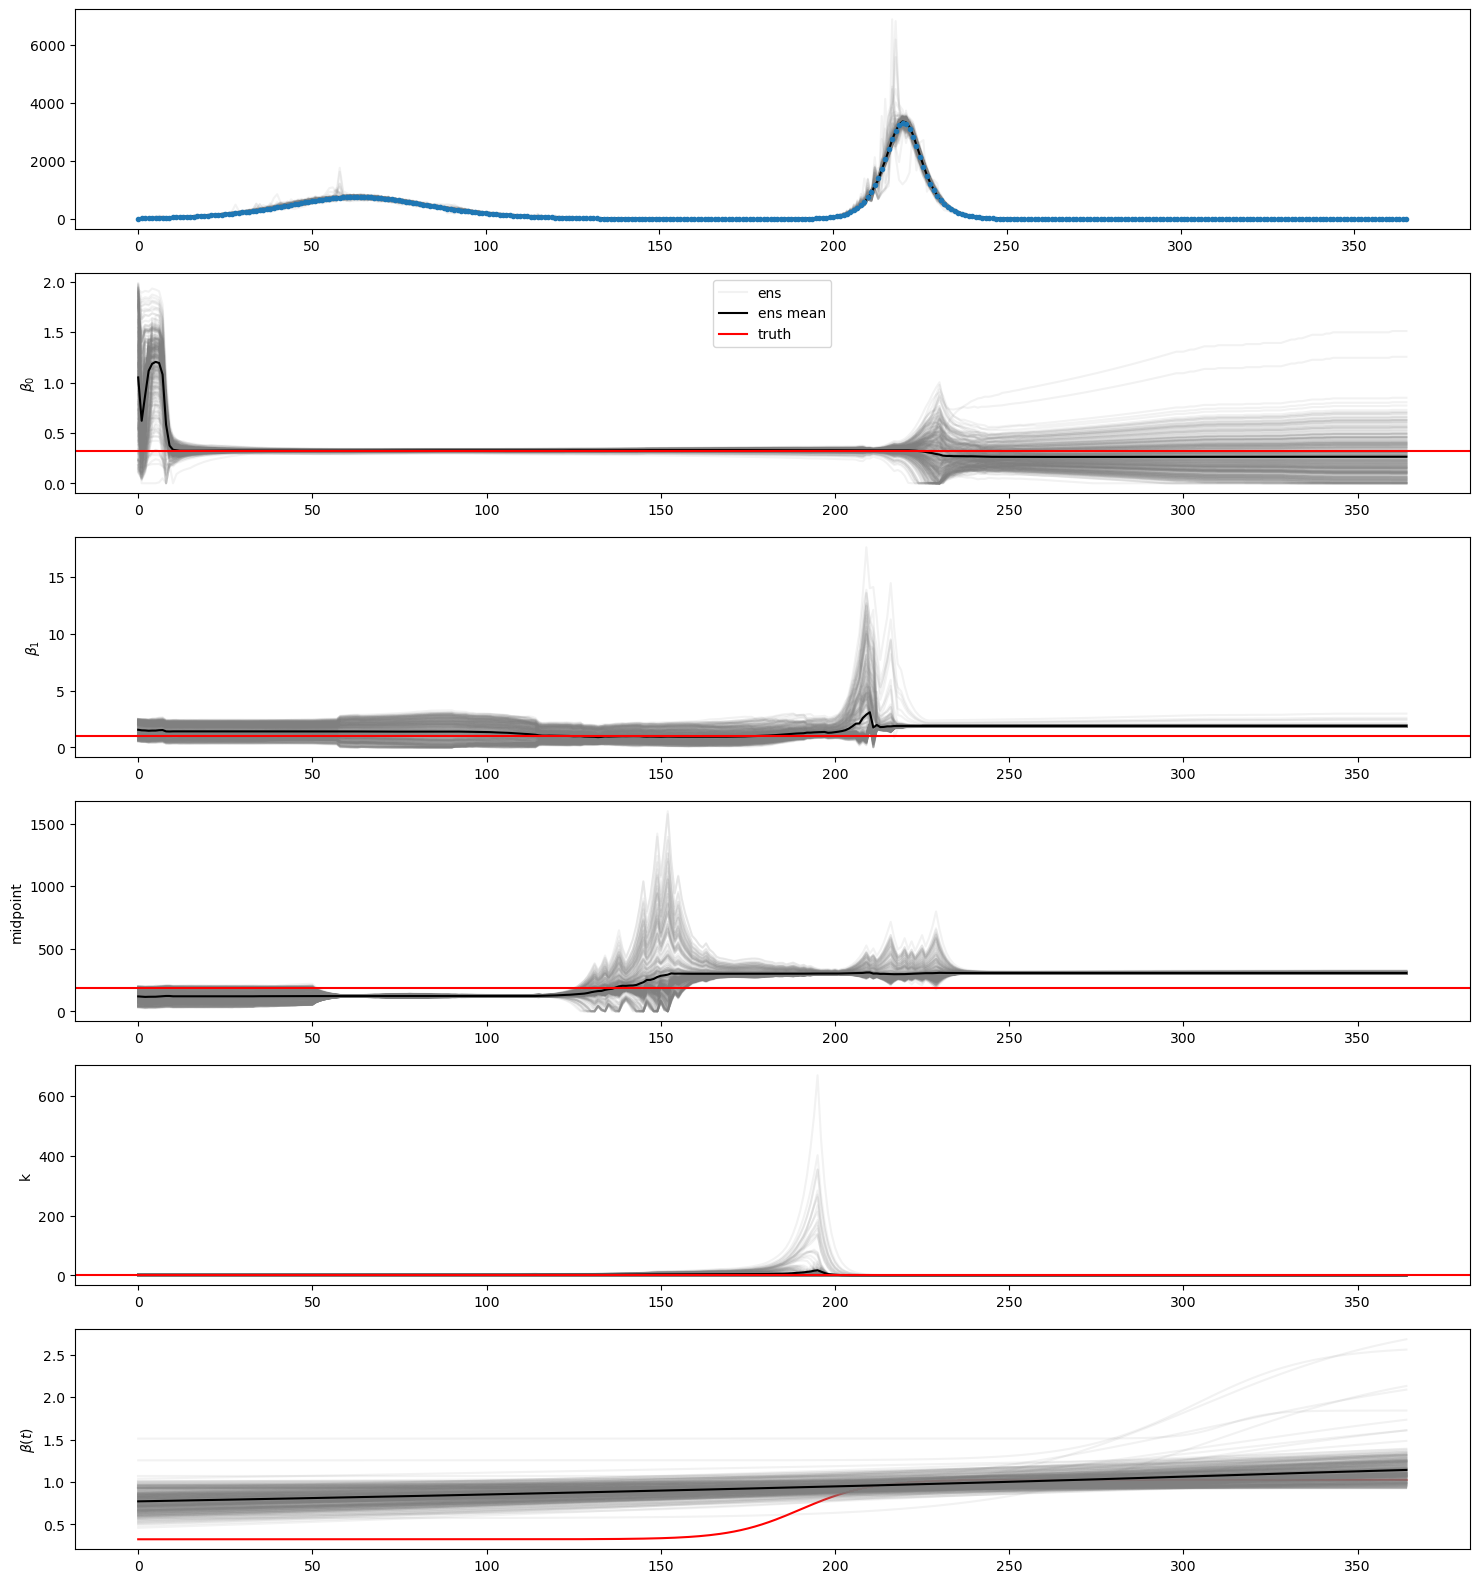

In [61]:
post = θ_list[-1]
t = np.arange(0, data.n_t)
sigmoid = [post.beta_0 + (post.beta_1 - post.beta_0) / (1 + np.exp(-post.k*(tt - post.midpoint))) for tt in t]

fig, ax = plt.subplots(6, figsize=(18,20))
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta_0 for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot([],[], 'gray', alpha=0.1, label='ens')
ax[1].plot(np.mean([θ.beta_0 for θ in θ_list], axis=1), color='black', label="ens mean")
ax[1].axhline(beta[0], color="red", label="truth")
ax[1].set_ylabel(r"$\beta_0$")
ax[1].legend()

ax[2].plot([θ.beta_1 for θ in θ_list], color="gray", alpha=0.1)
ax[2].plot(np.mean([θ.beta_1 for θ in θ_list], axis=1), color='black')
ax[2].axhline(beta[-1], color="red")
ax[2].set_ylabel(r"$\beta_1$")

ax[3].plot([θ.midpoint for θ in θ_list], color="gray", alpha=0.1)
ax[3].plot(np.mean([θ.midpoint for θ in θ_list], axis=1), color='black')
ax[3].axhline(data.midpoint, color="red")
ax[3].set_ylabel(r"midpoint")

ax[4].plot([θ.k for θ in θ_list], color="gray", alpha=0.1)
ax[4].plot(np.mean([θ.k for θ in θ_list], axis=1), color='black')
ax[4].axhline(data.k, color="red")
ax[4].set_ylabel(r"k")

ax[5].plot(beta, color="red")
ax[5].plot(sigmoid, color="gray", alpha=0.1)
ax[5].plot(np.mean(sigmoid, axis=1), color="black")
ax[5].set_ylabel(r"$\beta(t)$")



In [56]:
l = 1

x_list = np.array(x_list)
xhat_list = np.array(xhat_list)
θ_list = np.array(θ_list)

x_lag_list = []
θ_lag_list = []

for k in range(data.n_t-1):
    z = data.i[k+l]
    oev = np.maximum(10, z**2/50)
    H = np.array([0,0,0,1])

    ## Smooth STATES
    x = x_list[k,:,:]
    xhat = xhat_list[k+l,:,:]
        
    y = H@xhat
    ybar_hat = np.mean(y)
    Pyy = np.cov(y)
    Pb = np.cov(xhat)
    Pba = np.cov(x, xhat)[4:,4:]
    # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
    # eq 9
    K_lag = (H@Pba).T/(Pyy+oev)
    
    x_bar = np.mean(x, axis=1)
    xhat_bar = np.array([np.mean(xhat, axis=1)])
    # eq 8
    xbar_lag = x_bar + K_lag*(z - ybar_hat)
    # eq 15
    Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
    # eq 13
    x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)
    
    x_lag = np.clip(x_lag, 0, data.N)
    x_lag = SIR(*x_lag)
    x_lag_list.append(x_lag)
    
    
    ## Smooth PARAMS
    θ = θ_list[k,:,:]
    Pb = np.cov(θ,y)
    H = np.array([0,0,1])
    Pba = np.cov(θ,y)
    
    # eq 9
    K_lag = (H@Pba).T/(Pyy+oev)
    K_lag = K_lag[:-1]
    
    θ_bar = np.array([np.mean(θ, axis=1)]).T
    θhat_bar = θ_bar
    # eq 8
    θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
    # eq 15
    Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
    # eq 13
    θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])
    
    θ_lag = np.clip(θ_lag, 0, 10)
    θ_lag = ModelParams(*θ_lag)
    θ_lag_list.append(θ_lag)
    
# plot
x_lag_list = np.array(x_lag_list)
x_lag_means = np.mean(x_lag_list, axis=2)

fig, ax = plt.subplots(3)
ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
ax[0].plot(x_lag_means[:,0], color='black')
ax[0].plot(data.S, '.')

ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
ax[1].plot(x_lag_means[:,1], color='black')
ax[1].plot(data.I, '.')

ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
ax[2].plot(x_lag_means[:,2], color='black')
ax[2].plot(data.R, '.')

fθ_lag_list = np.array(θ_lag_list)

θ_lag_list = np.array(θ_lag_list)

fig, ax = plt.subplots(2)

ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(x_lag_means[:,3], color='black')
ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
# ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle(f'EnSRS window size {l} with adaptive inflation')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3)

In [ ]:
for l in np.arange(2,10):
    print(l)
    
    θ_list = np.array(θ_lag_list).copy()
    x_list = np.array(x_lag_list).copy()
    
    x_lag_list = []
    θ_lag_list = []

    for k in range(data.n_t-l):
        z = data.i[k+l]
        oev = np.maximum(10, z**2/50)
        H = np.array([0,0,0,1])

        ## Smooth STATES
        x = x_list[k,:,:]
        xhat = xhat_list[k+l,:,:]

        y = H@xhat
        ybar_hat = np.mean(y)
        Pyy = np.cov(y)
        Pb = np.cov(xhat)
        Pba = np.cov(x, xhat)[4:,4:]
        # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
        # eq 9
        K_lag = (H@Pba).T/(Pyy+oev)

        x_bar = np.mean(x, axis=1)
        xhat_bar = np.array([np.mean(xhat, axis=1)])
        # eq 8
        xbar_lag = x_bar + K_lag*(z - ybar_hat)
        # eq 15
        Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
        # eq 13
        x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)

        x_lag = np.clip(x_lag, 0, data.N)
        x_lag = SIR(*x_lag)
        x_lag_list.append(x_lag)


        ## Smooth PARAMS
        θ = θ_list[k,:,:]
        Pb = np.cov(θ,y)
        H = np.array([0,0,1])
        Pba = np.cov(θ,y)

        # eq 9
        K_lag = (H@Pba).T/(Pyy+oev)
        K_lag = K_lag[:-1]

        θ_bar = np.array([np.mean(θ, axis=1)]).T
        θhat_bar = θ_bar
        # eq 8
        θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
        # eq 15
        Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
        # eq 13
        θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])

        θ_lag = np.clip(θ_lag, 0, 10)
        θ_lag = ModelParams(*θ_lag)
        θ_lag_list.append(θ_lag)
    
    # plot
    x_lag_list = np.array(x_lag_list)
    x_lag_means = np.mean(x_lag_list, axis=2)

    fig, ax = plt.subplots(3)
    ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
    ax[0].plot(x_lag_means[:,0], color='black')
    ax[0].plot(data.S, '.')

    ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
    ax[1].plot(x_lag_means[:,1], color='black')
    ax[1].plot(data.I, '.')

    ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
    ax[2].plot(x_lag_means[:,2], color='black')
    ax[2].plot(data.R, '.')

    fθ_lag_list = np.array(θ_lag_list)

    θ_lag_list = np.array(θ_lag_list)

    fig, ax = plt.subplots(2)

    ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
    ax[0].plot(data.i, '.')
    ax[0].plot(x_lag_means[:,3], color='black')
    # ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

    ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
    ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
    ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
    # ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
    ax[1].set_xlabel('day')
    ax[1].set_ylabel(r'$\beta(t)$')

    fig.suptitle(f'EnSRS window size {l} with adaptive inflation')
